In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

#these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'FL': {}}#, 'RI': {}}
this_state = 'FL'

pop_total_denominator = 330759736
nDistricts = 435
target = pop_total_denominator / nDistricts


g = 0
scale = 20
map_buffer_ratio = .1
theproj = 3857 #{'init': 'epsg:9822'}
equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
desired_pct_area_overlap = 0.5

show_water = True
show_roads = False
water_area_tol = 1 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('state_name')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('state').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state_finder in these_states_dict.keys():
    these_states_dict[this_state_finder]['seats_old'] = state_seats_df[state_seats_df['stusab'] == this_state_finder]['seats_old'].values[0]
    these_states_dict[this_state_finder]['seats_new'] = state_seats_df[state_seats_df['stusab'] == this_state_finder]['seats_new'].values[0]
#pprint(these_states_dict)
#print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))


looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!
Got old and new numbers of districts for 1 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


In [8]:
# print('getting states...')
# state_all_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
# state_all_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_all_gdf['STATEFP'], errors='coerce')
# #state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
# #state_all_gdf[~state_all_gdf['STUSPS'].isin(['DC', 'PR', 'MP', 'VI', 'AS', 'GU'])][['STATEFP', 'STUSPS', 'NAME']].sort_values(by='STUSPS')
# state_all_gdf.columns


# Read redistricting geo data

In [9]:
s = time.time()
print('reading redistricting geography data for focus states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for focus states...
	reading flgeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 577,097 geographies in 0 minutes 24 seconds!


In [10]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state_finder in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state_finder]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state_finder))
    print('\t\t{0:} CRS = {1:}'.format(this_state_finder, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')

#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for FL...
		12 CRS = epsg:4269


Joined 5,160 tracts to shapefiles in 13.6 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


adding shapefiles...


Joined 27 congressional districts to shapefiles in 3.0 seconds!


In [14]:
s = time.time()

# state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
# state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()
    #state_numbers_include_list = list(set([pandas.to_numeric(x[89:91], errors='coerce') for x in waterfiles]))
    #[x for x in waterfiles if ()]
    #possible_state_list = state_codes_df[state_codes_df['STATE'] <= 56]['STATE'].tolist()
    for i in range(0, len(waterfiles)):
#        print(state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
#        print(water_gdf.head(1).T)
#        break
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')


e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


getting states...
getting counties...
Got 56 states and 3,234 counties in 7.8 seconds!


getting water areas...
	reading water file 0 of 67...
	reading water file 10 of 67...
	reading water file 20 of 67...
	reading water file 30 of 67...
	reading water file 40 of 67...
	reading water file 50 of 67...
	reading water file 60 of 67...
Got 1,212 water areas in 0 minutes 32.1 seconds!


getting CBSAs (metro areas)...
Got 939 CBSAs in 2.7 seconds!


getting places...
	reading place file 0 of 1...
Got 955 places in 1.0 seconds!


Done!


In [15]:
s = time.time()

print('setting up insets for {0:}...'.format(this_state))
insets = {}

insets['se'] = {}
insets['se']['how'] = 'districts'
insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
insets['se']['axes_position'] = [0.3, 0.01]
insets['se']['axes_rel_size'] = .255
insets['se']['districts'] = [21,22,23,24,27]
insets['se']['partial_districts'] = [18,20,25,26]
insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
insets['se']['title'] = 'Southeast Florida'
insets['se']['titlesize'] = 22
insets['se']['borderwidth'] = 3

insets['tpa'] = {}
insets['tpa']['how'] = 'districts'
#insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
insets['tpa']['axes_position'] = [0.03, 0.015]
insets['tpa']['axes_rel_size'] = 0.255
insets['tpa']['districts'] = [13,14]
insets['tpa']['partial_districts'] = [12, 15, 16]
insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
insets['tpa']['title'] = 'Tampa Bay'
insets['tpa']['titlesize'] = 22
insets['tpa']['borderwidth'] = 3

insets['orl'] = {}
insets['orl']['how'] = 'counties'
insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

insets['orl']['axes_position'] = [0.03, 0.26]
insets['orl']['axes_rel_size'] = 0.255
insets['orl']['districts'] = [7,10]
insets['orl']['partial_districts'] = [6,8,9,11,15]
insets['orl']['counties'] = ['Orange County', 'Seminole County']
insets['orl']['title'] = 'Orlando'
insets['orl']['titlesize'] = 22
insets['orl']['borderwidth'] = 3

insets['jax'] = {}
insets['jax']['how'] = 'counties'
insets['jax']['axes_position'] = [0.84, 0.87]
insets['jax']['axes_rel_size'] = 0.15
insets['jax']['districts'] = [4,5]
insets['jax']['partial_districts'] = [3]
insets['jax']['counties'] = ['Duval County']
insets['jax']['title'] = 'Jacksonville'
insets['jax']['titlesize'] = 22
insets['jax']['borderwidth'] = 3

insets['tally'] = {}
insets['tally']['how'] = 'places'
insets['tally']['axes_position'] = [0.84, 0.69]
insets['tally']['axes_rel_size'] = 0.15
insets['tally']['districts'] = [2,5]
insets['tally']['partial_districts'] = []
insets['tally']['counties'] = ['Leon County']
insets['tally']['places'] = ['Tallahassee']
insets['tally']['title'] = 'Tallahassee'
insets['tally']['titlesize'] = 22
insets['tally']['borderwidth'] = 3


for inset_name, inset in insets.items():
    print(inset_name)
    
    if ('bounds' in inset.keys()):
        inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
    else:
        if (inset['how'] == 'districts'):
            thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
        elif (inset['how'] == 'counties'):
            thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
        elif (inset['how'] == 'places'):
            thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
        xlims = [thegeo[0], thegeo[2]]
        ylims = [thegeo[1], thegeo[3]]        
        xspan = xlims[1] - xlims[0]
        yspan = ylims[1] - ylims[0]
        inset['aspect_ratio'] = xspan / yspan
        xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
        ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
        xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
        ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
        inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
        #print(inset['bounds'])
    
    inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
        box(
            inset['bounds'][0], 
            inset['bounds'][1], 
            inset['bounds'][2], 
            inset['bounds'][3]
        )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
    inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
#    print(inset['axes_size'])

all_inset_districts = []
for inset in insets.values():
    all_inset_districts += inset['districts']
    
main_map_districts = [x for x in list(range(1, these_states_dict[this_state]['seats_old']+1)) if x not in all_inset_districts]

main_map_districts += [x for x in insets['jax']['districts']]
main_map_districts += [x for x in insets['tally']['districts']]
main_map_districts = sorted(main_map_districts)

#print(main_map_districts)
e = time.time()
g += (e-s)
print('Done!')
#main_map_districts

setting up insets for FL...
se
tpa
orl
jax
tally
Done!


main map...
	plotting congressional districts...
		Plotting district 1...
		Plotting district 11...
		Plotting district 26...
	plotting census tracts...
	plotting water areas...
inset se...
	districts...
		Plotting District 21...
		Plotting District 22...
		Plotting District 23...
		Plotting District 24...
		Plotting District 27...
	partial districts...
		Plotting District 18...
		Plotting District 20...
		Plotting District 25...
		Plotting District 26...
	tracts...
	counties...
	water..
inset tpa...
	districts...
		Plotting District 13...
		Plotting District 14...
	partial districts...
		Plotting District 12...
		Plotting District 15...
		Plotting District 16...
	tracts...
	counties...
	water..
inset orl...
	districts...
		Plotting District 7...
		Plotting District 10...
	partial districts...
		Plotting District 6...
		Plotting District 8...
		Plotting District 9...
		Plotting District 11...
		Plotting District 15...
	tracts...
	counties...
	water..
inset jax...
	districts...
		Plotti

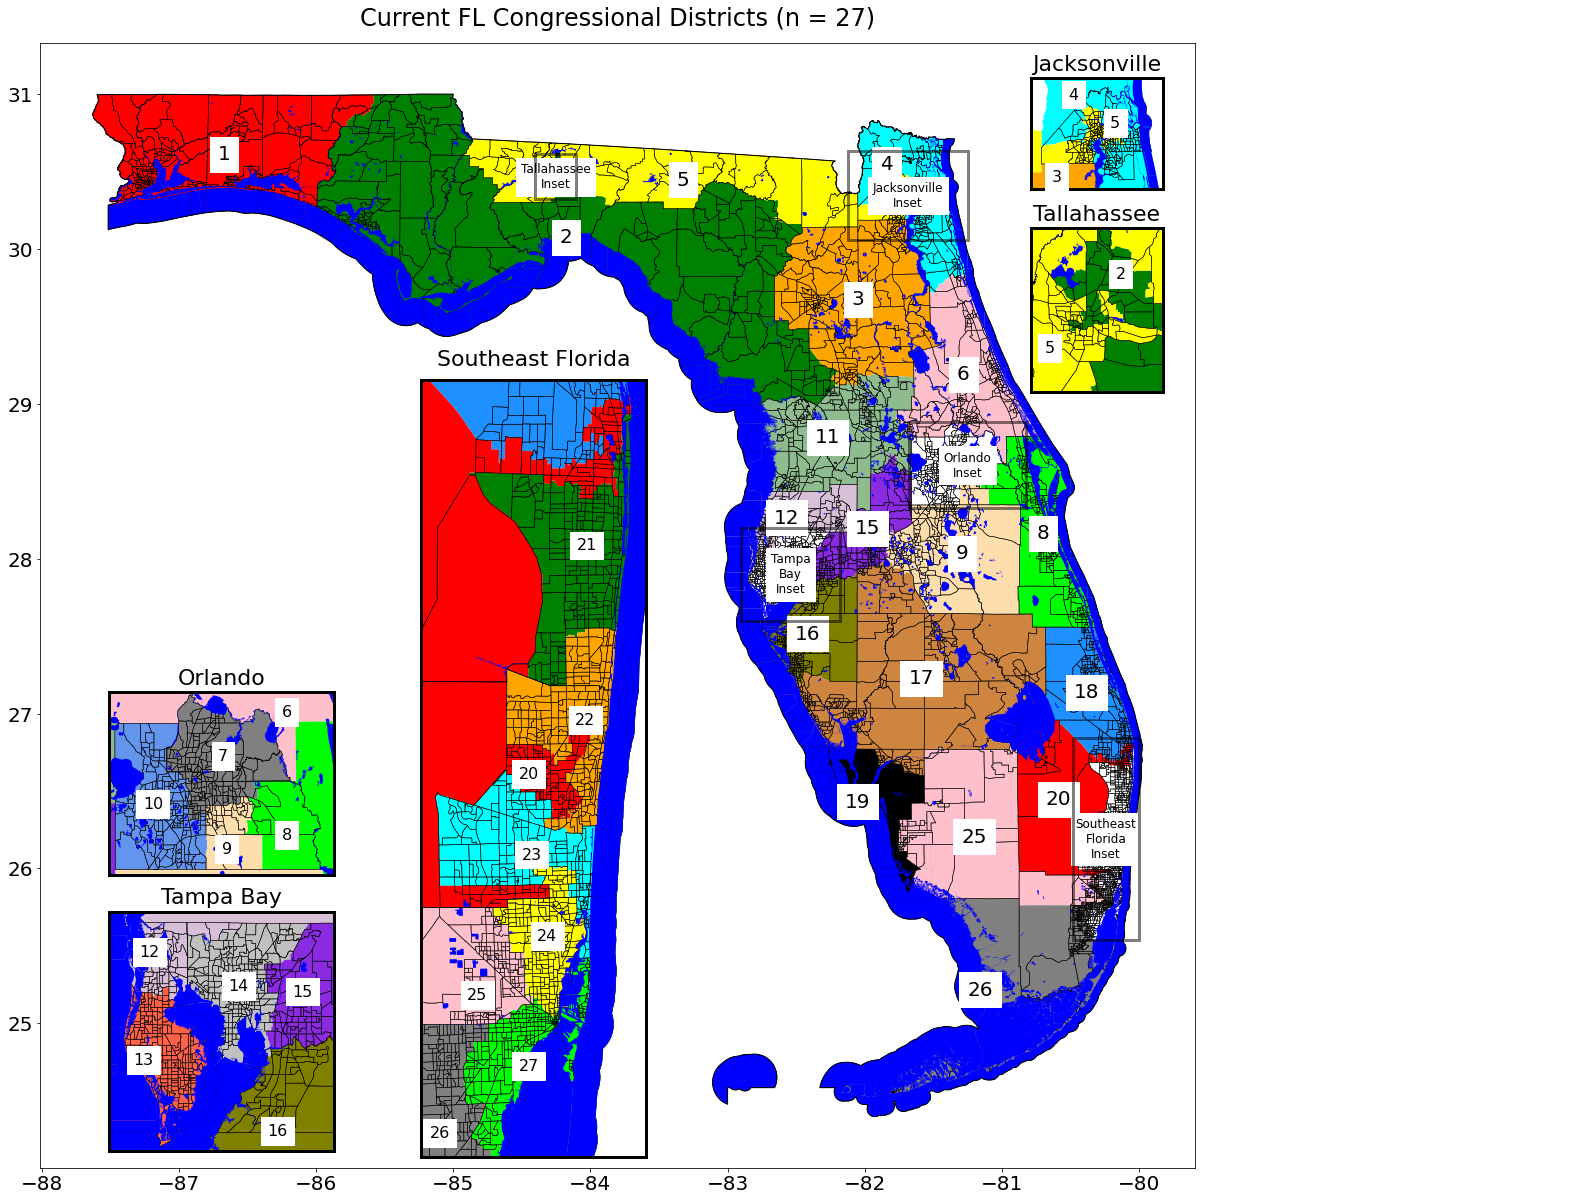

In [16]:
s = time.time()
#this_state = 'FL'
show_tracts = True
show_water = True

print('main map...')
print('\tplotting congressional districts...')
#print(state_gdf.head(1).T)

main_map_aspect_ratio = (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[0]) / (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[3] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1])


fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')

#all_districts = list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1))

legend_list = []
for thiscd in main_map_districts:
    if ((np.mod(thiscd, 10) == 1) | (thiscd == max(main_map_districts))):
        print('\t\tPlotting district {0:.0f}...'.format(thiscd))
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=ax, color=district_color_cycle[thiscd])
    legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    annotator = thiscd
    centerpoint = (cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)]['INTPTLON'].values[0], cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)]['INTPTLAT'].values[0])
    ax.annotate(annotator, centerpoint, 
                color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting water areas...')
    water_gdf[water_gdf['STUSAB'] == this_state].plot(ax=ax, color='blue')

state_gdf[state_gdf['STUSPS'] == this_state].plot(ax=ax, color='none', edgecolor='black')


    
#ax.legend(handles=legend_list, fontsize=10, loc='lower right')

ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
    this_state, 
    these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
), fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)


for inset_name, inset in insets.items():
    print('inset {0:}...'.format(inset_name))
    inset['axes'] = ax.inset_axes([inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]])
    inset['axes'].set_aspect('equal')
    print('\tdistricts...')
    for thiscd in inset['districts']:
        print('\t\tPlotting District {0:.0f}...'.format(thiscd))
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=inset['axes'], color=district_color_cycle[thiscd])
        annotator = thiscd 
        centerpoint = (cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
        inset['axes'].annotate(annotator, centerpoint, 
                    color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
    print('\tpartial districts...')
    for thiscd in inset['partial_districts']:
        print('\t\tPlotting District {0:.0f}...'.format(thiscd))
        cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == thiscd)].plot(ax=inset['axes'], color=district_color_cycle[thiscd])
    if (show_tracts):
        print('\ttracts...')
        tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(inset['counties']))].plot(ax=inset['axes'], color='none', edgecolor='black', lw=0.5)
        print('\tcounties...')
        county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].apply(lambda x: x+' County' in inset['counties']))].plot(ax=inset['axes'], color='none', edgecolor='black', lw=inset['borderwidth']/8)
    
    if (show_water):
        print('\twater..')
        water_gdf[water_gdf['STUSAB'] == this_state].plot(ax=inset['axes'], color='blue')

    inset['axes'].set_xlim(inset['bounds'][0], inset['bounds'][2])
    inset['axes'].set_ylim(inset['bounds'][1], inset['bounds'][3])
    
    for this_side in ['top', 'bottom', 'left', 'right']:
        inset['axes'].spines[this_side].set_linewidth(inset['borderwidth'])
    inset['axes'].set_title(inset['title'], fontsize=inset['titlesize'], y=1.01)
    inset['axes'].set_xticks([])
    inset['axes'].set_yticks([])

    rectpatch, connects = ax.indicate_inset_zoom(inset['axes'], edgecolor="black", linewidth=inset['borderwidth'])
    citylabel = '{0:}\nInset'.format(inset['title'].replace(' ','\n'))
    citylabel_center = [rectpatch.get_x()+(rectpatch.get_width()/2), rectpatch.get_y()+(rectpatch.get_height()/2)]
    ax.annotate(citylabel, citylabel_center, color='black', backgroundcolor='white',  ha='center', va='center', fontsize=12)
    
    for j in range(0,4):
        connects[j].set_visible(False)

print('Adding some district labels by hand...')
insets['jax']['axes'].annotate(3, (-81.95,30.12), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['jax']['axes'].annotate(5, (-81.56,30.4), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['tally']['axes'].annotate(2, (-84.2, 30.53), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tally']['axes'].annotate(5, (-84.36, 30.4), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['orl']['axes'].annotate(6, (-81, 28.82), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['orl']['axes'].annotate(8, (-81, 28.45), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['orl']['axes'].annotate(9, (-81.23, 28.41), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['tpa']['axes'].annotate(12, (-82.77, 28.1), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tpa']['axes'].annotate(15, (-82.28, 28), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['tpa']['axes'].annotate(16, (-82.36, 27.65), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)

insets['se']['axes'].annotate(20, (-80.25, 26.18), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['se']['axes'].annotate(25, (-80.36, 25.81), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)
insets['se']['axes'].annotate(26, (-80.44, 25.58), color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)



# print('saving figure...')
# fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
#[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]



In [17]:
state_target = cd_gdf[cd_gdf['STUSAB'] == this_state]['POP100'].sum() / these_states_dict[this_state]['seats_new']
print('{0:,.0f} districts, each with {1:,.0f} people!'.format(these_states_dict[this_state]['seats_new'], state_target))

28 districts, each with 769,221 people!


In [18]:
print('Finding CBSAs in {0:}...'.format(this_state))

cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'geometry']].sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[tract_gdf.geometry.apply(lambda x: x.within(thisrow.geometry))]['POP100'].sum()
    
print('Found populations for {0:,.0f} CBSAs (total pop = {1:,.0f})!'.format(len(cbsa_gdf['POP100'].dropna()), cbsa_gdf['POP100'].sum()))

main_map_aspect_ratio = (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[2] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[0]) / (unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[3] - unary_union(state_gdf[state_gdf['STUSPS'] == this_state].geometry.tolist()).bounds[1])


# fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
# ax.set_aspect('equal')


# cbsa_gdf[cbsa_gdf['POP100'].notnull()].plot(ax=ax, color='none', edgecolor='yellow', lw=3)
# state_gdf[state_gdf['STUSPS'] == this_state].plot(ax=ax, color='none', edgecolor='black', lw=3)
# county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].plot(ax=ax, color='none', edgecolor='black')
# plt.show()


cbsa_gdf[cbsa_gdf['POP100'].notnull()][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)




Finding CBSAs in FL...
Found populations for 29 CBSAs (total pop = 21,218,829)!


,NAME,POP100
GEOID,,
33100,"Miami-Fort Lauderdale-Pompano Beach, FL",6138333.0
45300,"Tampa-St. Petersburg-Clearwater, FL",3175275.0
36740,"Orlando-Kissimmee-Sanford, FL",2673376.0
27260,"Jacksonville, FL",1605848.0
35840,"North Port-Sarasota-Bradenton, FL",833716.0
15980,"Cape Coral-Fort Myers, FL",760822.0
29460,"Lakeland-Winter Haven, FL",725046.0
19660,"Deltona-Daytona Beach-Ormond Beach, FL",668921.0
37340,"Palm Bay-Melbourne-Titusville, FL",606612.0


In [19]:
# s = time.time()
# doit = True


# print('TARGET: {0:,.0f}'.format(state_target))
# #print('\n')
# #state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']

# tract_gdf.loc[:, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[

    

    
# # ['St. Johns County',6],
# #     ['Flagler County',6],

# # ['Citrus County',11],
# #     ['Sumter County',11],

# # ['Lake County', 10],

# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# tract_gdf.loc[:, 'new_district'] = tract_df.reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


# place_mapper_df = pandas.DataFrame(data=[
    
    
# ], columns=['NAME', 'new_district_by_place'])



# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))

# print('DANGER: includes duplicate place names, fixing...')
# print(place_gdf[place_gdf['NAME'].isin(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicated_places_gdf['NAME'])]['NAME'].drop_duplicates().tolist())][['NAME', 'NAMELSAD']])


# #place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicated_places_gdf['NAME'].drop_duplicates())].index, axis=0)
# #place_mapper_gdf = pandas.concat((place_mapper_gdf, geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['NAMELSAD'] == 'Plantation city'].reset_index(), how='inner', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))), axis=0)

# # print('Selected Plantation city!')
# # print('\n')

# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     tracts_here = []
#     tracts_within = tract_gdf[
#                 (tract_gdf['new_district'].isnull()) & 
#                 (tract_gdf.geometry.within(
#                     unary_union(
#                         place_mapper_gdf[
#                             place_mapper_gdf['new_district_by_place'] == i
#                         ].geometry.tolist())
#                     )
#                 )
#             ].index.tolist()
#     tracts_intersect = tract_gdf[
#             (tract_gdf['new_district'].isnull()) & 
#             (tract_gdf.geometry.intersects(
#                 unary_union(
#                     place_mapper_gdf[
#                         place_mapper_gdf['new_district_by_place'] == i
#                     ].geometry.tolist())
#                 )
#             )
#             & ~(tract_gdf.index.isin(tracts_within))
#         ].index.tolist()

#     if ((len(tracts_within) + len(tracts_intersect)) > 0):
#         print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
#     if (len(tracts_within) > 0):
#         print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
#         tracts_here += tracts_within
#     if (len(tracts_intersect) > 0):
#         print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
#         if (doit):
#             cnt = 0
#             for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
#                 cnt += 1
#                 if (np.mod(cnt, 10) == 0):
#                     print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
#                 this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
#                 intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
#                     epsg=equal_area_crs).geometry.intersection(
#                                     unary_union(
#                             place_mapper_gdf[
#                                 place_mapper_gdf['new_district_by_place'] == i
#                             ].to_crs(epsg=equal_area_crs).geometry.tolist())
#                         ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
#                 intersection_pct = intersection_area / this_tract_area



#                 #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
#                 if (intersection_pct >= desired_pct_area_overlap):
#                     tracts_here.append(ix)
#                     #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
#                 #break

#             print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
#             print('\n')
#             tract_gdf.loc[tracts_here, 'new_district'] = i

#         tract_gdf.loc[(tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist()))), 'new_district'] = i


# print('Assigning districts by tract number...')













# # tract_gdf.loc[['1400000US12059960100', '1400000US12059960201', '1400000US12059960202', '1400000US12059960300'], 'new_district'] = 1  # W Holmes County


# # tract_gdf.loc[['1400000US12059960401', '1400000US12059960402', '1400000US12059960403'], 'new_district'] = 2  # E Holmes County





# # tract_gdf.loc[['1400000US12031016801','1400000US12031016803','1400000US12031016804', '1400000US12031016807','1400000US12031016808','1400000US12031016809', '1400000US12031016810','1400000US12031016811','1400000US12031016812', '1400000US12031016813'], 'new_district'] = 6     # SE Duval County
# # tract_gdf.loc[['1400000US12031014203', '1400000US12031014204', '1400000US12031014206', '1400000US12031014423', '1400000US12031014424', '1400000US12031014413', '1400000US12031014425', '1400000US12031014426'], 'new_district'] = 6     # SE Duval County
# # tract_gdf.loc[['1400000US12127080102', '1400000US12127080201', '1400000US12127083203', '1400000US12127083206'], 'new_district'] = 6     # Daytona Beach area
# # tract_gdf.loc[['1400000US12127080805','1400000US12127080809','1400000US12127080901', '1400000US12127080902','1400000US12127081001','1400000US12127081002', '1400000US12127081701'], 'new_district'] = 6     # Daytona Beach area
# # tract_gdf.loc[['1400000US12019030206', '1400000US12019030209', '1400000US12019030306', '1400000US12019030708', '1400000US12019030905'], 'new_district'] = 6     # N Clay County




# # tract_gdf.loc[['1400000US12053040400', '1400000US12053040501', '1400000US12053040602', '1400000US12053041501', '1400000US12053041502', '1400000US12053041601', '1400000US12053041602'], 'new_district'] = 11     # Hernando County
# # tract_gdf.loc[['1400000US12053040201', '1400000US12053040202', '1400000US12053040601', '1400000US12053040701'], 'new_district'] = 11     # Hernando County
# # tract_gdf.loc[['1400000US12075970400', '1400000US12075970501', '1400000US12075970600', '1400000US12075970700', '1400000US12075970502', '1400000US12075990000'], 'new_district'] = 11      # Rest of Levy County
# # tract_gdf.loc[['1400000US12083000101', '1400000US12083000102', '1400000US12083000201', '1400000US12083000202', '1400000US12083000203', '1400000US12083000302', '1400000US12083000303', '1400000US12083000304'], 'new_district'] = 11     #### West Marion County
# # tract_gdf.loc[['1400000US12083000703', '1400000US12083000704', '1400000US12083000705', '1400000US12083000706', '1400000US12083000707', '1400000US12083000803', '1400000US12083000804', '1400000US12083000805', '1400000US12083000806', '1400000US12083000807', '1400000US12083000808', '1400000US12083000809', '1400000US12083000810', '1400000US12083000811'], 'new_district'] = 11     #### West Marion County
# # tract_gdf.loc[['1400000US12083000901', '1400000US12083000903', '1400000US12083000904', '1400000US12083001003', '1400000US12083001005', '1400000US12083001102', '1400000US12083001103', '1400000US12083001105', '1400000US12083001106'], 'new_district'] = 11     #### West Marion County
# # tract_gdf.loc[['1400000US12083001205', '1400000US12083001208', '1400000US12083001500'], 'new_district'] = 11     #### West Marion County
# # tract_gdf.loc[['1400000US12083002201', '1400000US12083002203', '1400000US12083002302', '1400000US12083002401', '1400000US12083002402', '1400000US12083002503', '1400000US12083002505', '1400000US12083002506'], 'new_district'] = 11     #### West Marion County
# # tract_gdf.loc[['1400000US12083002602', '1400000US12083002604', '1400000US12083002607', '1400000US12083002608', '1400000US12083002610', '1400000US12083002703', '1400000US12083002704', '1400000US12083002705', '1400000US12083002706'], 'new_district'] = 11     #### West Marion County








# # # print('Except ocean tracts...')
# # # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


# # nDone = 0
# # total_difference = 0
# # total_sum = 0
# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         nDone += 1
#         total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
#         total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# # print('\n')        
# # print('saving outfile...')
# # tract_gdf['new_district'].to_csv(script_dir+'florida-so-far.csv')


# # e = time.time()
# # g += (e-s)

# # print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))

# # #print('\n')
# # #print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# # print('Done!')

In [20]:
s = time.time()
doit = True
examine_duplicates = False

print('TARGET: {0:,.0f}'.format(state_target))
#print('\n')
#state_target = cd_gdf['POP100'].sum() / these_states_dict[list(these_states_dict.keys())[0]]['seats_new']

tract_gdf.loc[:, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[
['Monroe County',28],

['Seminole County',7],

['St. Johns County',5],
    ['Flagler County',5],
    
['Hardee County',19],
    ['DeSoto County',19],
    ['Collier County',19],
        
['Escambia County',1],
     ['Santa Rosa County',1],
     ['Okaloosa County',1],
    
['Holmes County',2],
    ['Washington County',2],
    ['Bay County',2],
    ['Gadsden County',2],
    ['Calhoun County',2],
    ['Gulf County',2],
    ['Liberty County',2],    
    ['Franklin County',2],   
    ['Jackson County',2],   
    ['Wakulla County',2],   
    ['Leon County',2],   
    ['Jefferson County',2],   
    ['Madison County',2],   
    ['Taylor County',2],   

['Hamilton County',3],   
    ['Suwannee County',3],   
    ['Dixie County',3],
    ['Lafayette County',3],   
    ['Columbia County',3],   
    ['Gilchrist County',3],  
    ['Nassau County',3],   
    ['Baker County',3],   
    ['Union County',3],   
    ['Bradford County',3],   
    ['Alachua County',3],   
    
['Citrus County',11], 
    ['Hernando County',11], 

], columns=['COUNTY_NAME', 'new_district_by_county'])
tract_gdf.loc[:, 'new_district'] = tract_df.reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']


place_mapper_df = pandas.DataFrame(data=[
['Miami', 27],
    ['Key Biscayne',27],
    ['Miami Beach',27], 
    ['North Bay Village',27],    
    ['Coral Gables',27], 
    ['Miami Shores',27],
    ['North Miami',27],
    ['West Miami', 27],
    ['South Miami', 27],
    ['Golden Glades',27],
    
    
['Florida City', 28],
    ['Homestead', 28],
    ['Homestead Base', 28],    
    ['Leisure City', 28],        
    ['Naranja', 28],            
    ['Princeton', 28],            
    ['Goulds', 28],         
    ['Cutler Bay', 28],     
    ['South Miami Heights', 28],  
    ['Richmond West', 28],  
    ['Palmetto Bay', 28],  
    ['West Perrine', 28],  
    ['Richmond Heights', 28], 
    ['Palmetto Estates', 28],  
    ['Kendall', 28],         
    ['The Crossings', 28],         
    ['The Hammocks', 28],     
    ['Pinecrest', 28],     
    
    
['Kendall West', 26],   
     ['Kendale Lakes',26],
     ['Sunset',26],
     ['Glenvar Heights',26],
     ['Westwood Lakes',26],
     ['Olympia Heights',26],
     ['Tamiami',26],
     ['Westchester',26],
     ['Fountainebleau',26],
     ['Sweetwater',26],
     ['Doral',26],
     ['Virginia Gardens',26],
    ['Coral Terrace',26],
    ['Medley',26],
    ['Hialeah',26],
    ['Brownsville',26],
    ['Gladeview',26],
    
    
['North Miami Beach',25],
    ['Sunny Isles Beach',25], 
    ['Golden Beach',25], 
    ['Aventura',25], 
    ['Ojus',25], 
    ['Hallandale Beach',25], 
    ['Pembroke Park',25], 
    ['West Park',25], 
    ['Hollywood',25],
    ['Dania Beach',25],
   ['Fort Lauderdale',25],
    ['Wilton Manors',25],
    ['Lazy Lake',25],
    ['Oakland Park',25],
    ['Lauderdale-by-the-Sea',25],
    ['Pompano Beach',25],
    ['Lighthouse Point',25], 
    ['Hillsboro Beach',25], 
    
    
    
['West Little River',24],
    ['Pinewood', 24],
    ['Westview',24], 
    ['Opa-locka',24], 
    ['Ives Estates', 24],
    ['Palm Springs North',24], 
    ['Country Club',24], 
    ['Miami Gardens',24], 
    ['Miami Lakes',24], 
    ['Palm Springs North',24],
    ['Miramar',24], 
    ['Pembroke Pines',24], 
    ['Weston',24], 
    ['Southwest Ranches',24], 
    ['Cooper City',24], 

    
['Davie',23],
   ['Plantation',23],    
   ['Broadview Park',23], 
    ['Sunrise',23],
    ['Lauderhill',23],
    ['Lauderdale Lakes',23],
    ['Tamarac',23], 
    ['North Lauderdale',23],
    ['Margate',23],
    ['Coral Springs',23],
    ['Coconut Creek',23],
    
    
    
['Deerfield Beach',22],
    ['Boca Raton',22],
    ['Highland Beach',22],
    ['Delray Beach',22],
    ['Gulf Stream',22], 
    ['Briny Breezes',22], 
    ['Ocean Ridge',22],
    ['Boynton Beach',22],
    ['San Castle',22],
    ['Hypoluxo',22],
    ['Lantana',22],
    ['Lake Worth Beach',22],
    ['Atlantis',22],
    ['Seminole Manor',22],
    ['Kenwood Estates',22],
    ['Palm Beach',22],
    ['West Palm Beach',22],
    ['Greenacres',22],
    ['Palm Springs',22],
    ['Lake Clarke Shores',22],
    ['Pine Air',22],
    ['Westgate',22],

    
    
['Parkland',21],
    ['Watergate',21],
    ['Palm Beach Gardens',21], 
    ['Jupiter Farms',21],
    
    
    
['Mangonia Park',20], 
    ['Riviera Beach',20], 
    ['Palm Beach Shores',20], 
    ['Lake Park',20], 
    ['North Palm Beach',20], 
    ['Juno Beach',20],
    ['Limestone Creek',20], 
    ['Jupiter',20], 
    ['Tequesta',20],    
    ['Micco',20], 


['Tampa',14],
    ["Town 'n' Country",14],
    ['Egypt Lake-Leto',14],
    ['Temple Terrace',14],
    ['East Lake-Orient Park',14],
    ['Lutz',14],
    ['Lake Magdalene',14],
    ['Carrollwood',14],
    ['Northdale',14],
    ['Citrus Park',14],


    
['St. Petersburg', 13],
    ['Pinellas Park',13],
    ['Clearwater',13],
    ['Gulfport',13],
    ['St. Pete Beach',13],
    ['Treasure Island',13],
    ['Lealman',13],
    ['West Lealman',13],
    ['South Pasadena',13],
    ['Kenneth City',13],
    ['Bear Creek',13],
    ['Largo',13],
    ['Seminole',13],
    ['Bardmoor',13],
    ['South Highpoint',13],
    ['Bay Pines',13],
    ['Madeira Beach',13],
    ['Redington Beach',13],
    ['North Redington Beach',13],
    ['Redington Shores',13],
    ['Indian Rocks Beach',13],
    ['Indian Shores',13],
    ['Ridgecrest',13],
    ['Belleair',13],
    ['Belleair Beach',13],
    ['Belleair Bluffs',13],
    ['Harbor Bluffs',13],

    
    
['Dunedin',12],
    ['Safety Harbor',12],
    ['East Lake',12], 
    ['Oldsmar',12], 
    ['Palm Harbor',12], 
    ['Tarpon Springs',12],
    ['Keystone',12], 
    ['Westchase',12], 
    ['Cheval',12], 
    ['Holiday',12], 
    ['Key Vista',12], 
    ['Beacon Square',12], 
    ['Elfers',12], 
    ['Port Richey',12], 
    ['New Port Richey',12], 
    ['New Port Richey East',12],
    ['Jasmine Estates',12], 
    ['Bayonet Point',12], 
    ['Hudson',12], 
    ['Trinity',12], 
    ['River Ridge',12], 
    ['Moon Lake',12], 
    ['Heritage Pines',12],
    ['Quail Ridge',12],
    ['Odessa',12],
    ["Land O' Lakes",12],
    ['Wesley Chapel',12],
    ['Pasadena Hills',12],
    ['Zephyrhills',12],
    ['Zephyrhills West',12],
    ['Connerton',12],
    
    
    
['Thonotosassa',15],
    ['Mango',15],
    ['Seffner',15], 
    ['Palm River-Clair Mel',15], 
    ['Brandon',15], 
    ['Valrico',15], 
    ['Bloomingdale',15], 
    ['Progress Village',15], 
    ['Gibsonton',15], 
    ['Riverview',15],  
    ['Fish Hawk',15],
    ['Apollo Beach',15],
    ['Balm',15],
    ['Ruskin',15],
    ['Sun City Center',15],
    ['Wimauma',15],
    ['Plant City',15],    
    ['Medulla',15], 
     ['Lakeland',15],
    ['Kathleen',15],
    
    
    
    

['Orlando',8],
    ['Conway',8],
    ['Holden Heights',8], 
    ['Oak Ridge',8], 
    ['Sky Lake',8], 
    ['Pine Castle',8], 
    ['Edgewood',8], 
    ['Belle Isle',8],
    ['Pine Hills',8], 
    ['Winter Park',8], 
    ['Orlovista',8], 
    ['Fairview Shores',8], 
    ['Eatonville',8], 
    ['Meadow Woods',8], 
    ['Doctor Phillips',8], 
    ['Lockhart',8],
    ['Maitland',8], 
    ['Gotha',8], 
    ['Windermere',8], 
    ['Lake Butler',8],
    ['Bay Hill',8], 
    ['Clarcona',8], 
    
    


['Horizon West',9],
    ['Bay Lake',9],
    ['Lake Buena Vista',9],
   ['Hunters Creek',9],    
   ['Williamsburg',9],
    ['Buenaventura Lakes',9],
    ['Kissimmee',9],
    ['Celebration',9],
    ['Poinciana',9],
    ['St. Cloud',9],
    ['Haines City',9],
    ['Lake Alfred',9],
    ['Auburndale',9],
    ['Lake Hamilton',9], 
    ['Dundee',9], 
    ['Winter Haven',9], 
    ['Cypress Gardens',9],
    ['Lake Wales',9], 
    ['Polk City',9], 
    ['Inwood',9], 

    
    

['Goldenrod',7], 
    ['Azalea Park',7], 
    ['Rio Pinar',7], 
    ['Union Park',7], 
    ['Alafaya',7],
    ['Bithlo',7],
    ['Wedgefield',7],
    
    


    
    
['Bellair-Meadowbrook Terrace',5], 
    ['Oakleaf Plantation',5], 
    ['Lakeside',5], 
    ['Asbury Lake',5], 
    ['Fleming Island',5],
    ['Orange Park',5], 
    ['Green Cove Springs',5], 
    ['Palatka',5],     
    
    
    
    
['Memphis',16], 
    ['Palmetto',16], 
    ['Bradenton',16], 
    ['West Bradenton',16], 
    ['South Bradenton',16], 
    ['Samoset',16], 
    ['West Samoset',16], 
    ['Ellenton',16], 
    ['Desoto Acres',16], 
    ['The Meadows',16], 
    ['Kensington Park',16], 
    ['North Sarasota',16], 
    ['Sarasota',16], 
    ['Fruitville',16], 
    ['Pinecraft',16], 
    ['Sarasota Springs',16], 
    ['Southgate',16], 
    ['Siesta Key',16], 
    ['Ridge Wood Heights',16], 
    ['South Sarasota',16], 
    ['South Gate Ridge',16], 
    ['Bee Ridge',16],
    ['Gulf Gate',16],
    ['Palmer Ranch',16],
    ['Vamo',16],
    ['Osprey',16],
    ['Laurel',16],
    ['Nokomis',16],
    ['Venice',16],
    ['South Venice',16],
    ['North Port',16],    
    
    
    
['Manasota Key',18], 
    ['Rotonda',18], 
    ['Port Charlotte',18], 
    ['Charlotte Harbor',18], 
    ['Charlotte Park',18], 
    ['Cleveland',18], 
    ['Punta Gorda',18],
    ['Sanibel',18], 
    ['Cape Coral',18], 
    ['Suncoast Estates',18], 
    ['North Fort Myers',18], 
    ['Fort Myers',18],
    ['Tice',18], 
    ['Whiskey Creek',18],
    ['McGregor',18], 
    ['Villas',18], 
    ['Cypress Lake',18], 
    ['Iona',18],
    ['Estero',18], 
    ['Three Oaks',18],
    ['San Carlos Park',18], 
    ['Gateway',18],
    ['Verandah',18], 
    ['Buckingham',18], 
    ['Fort Myers Shores',18], 
    ['Olga',18], 
    ['Punta Rassa',18], 
    ['Alva',18], 
    ['Charleston Park',18],     
    
    
    
    
['Fort Denaud',19], 
    ['LaBelle',19], 
    ['Port LaBelle',19],
    ['Lehigh Acres',19],
    ['Bonita Springs',19],
    ['Sebring',19],
    
    
    
    
['Avon Park',17],
    ['Frostproof',17], 
    ['Crooked Lake Park',17], 
    ['Alturas',17],
    ['Babson Park',17],
    ['Highland Park',17],
    ['Hillcrest Heights',17],
    ['Fort Meade',17],
    ['Bartow',17],
    ['Willow Oak',17], 
    ['Fuller Heights',17], 
    ['Lakeland Highlands',17], 
    ['Highland City',17],
    ['Wahneta',17],
    ['Eagle Lake',17],
    ['Fussels Corner',17],
    ['Jan Phyl Village',17],
    ['Grant-Valkaria',17],
    ['Malabar',17],
    ['Palm Bay',17],
    ['Melbourne',17],
    ['Melbourne Beach',17],
    ['West Melbourne',17],
    ['Indialantic',17],
    ['Palm Shores',17],
    ['Indian Harbour Beach',17],
    ['Satellite Beach',17],
    ['Merritt Island',17],
    ['Viera East',17],
    ['Rockledge',17],
    ['Cocoa West',17],
    
    
['Miramar Beach',1], 
    ['Freeport',1], 
    ['DeFuniak Springs',1],


['Middleburg',3],
    
    
['Shady Hills',11],
    ['Dade City',11],
    ['Ocala',11], 
    ['Marion Oaks',11], 
    ['Liberty Triangle',11], 
    ['Ocala',11], 
    ['Ocala Estates',11], 
    ['Silver Springs Shores',11],
    ['Dunnellon',11], 
    ['On Top of the World',11], 
        
    
    
['Zellwood',10], 
    ['Apopka',10], 
    ['South Apopka',10], 
    ['Paradise Heights',10], 
    ['Ocoee',10],
    ['Winter Garden',10], 
    ['Tildenville',10], 
    ['Oakland',10],
    ['Four Corners',10],
    ['The Villages',10],
    ['Clermont',10], 
    ['Groveland',10], 
    ['Montverde',10], 
    ['Minneola',10], 
    ['Howey-in-the-Hills',10], 
    ['Fruitland Park',10], 
    ['Yalaha',10], 
    ['Okahumpka',10], 
    ['Leesburg',10], 
    ['Tavares',10],
    ['Eustis',10],
    ['Mount Plymouth',10],
    ['Lady Lake',10],
    
    
], columns=['NAME', 'new_district_by_place'])



print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


duplicate_place_names_list = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'].isin(place_mapper_gdf['NAME'].tolist())) & (place_gdf['NAME'].duplicated() == True)]['NAME'].tolist()
if (len(duplicate_place_names_list) > 0):
    all_duplicated_tracts_to_show = []
    print('\n')
    print('DANGER: list of selected places includes duplicate place names:')
    
    for this_duplicate_place_name in duplicate_place_names_list:
        print('----- {0:} -----'.format(this_duplicate_place_name))
        if (examine_duplicates):
            for ix, thisrow in place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'] == this_duplicate_place_name)].iterrows():    
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))    
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        if (otherrow.geometry.intersects(thatrow.geometry)):
                            this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                            this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                            this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                            if (this_tract_intersection_pct >= desired_pct_area_overlap):
                                print('\t\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                                included_tracts.append(kx)
                print('\t\t\t{0:} includes {1:} tracts containing {2:,.0f} people!'.format(thisrow['NAMELSAD'], len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')
                all_duplicated_tracts_to_show += included_tracts
            fig, ax = plt.subplots(1,1)
            state_gdf[state_gdf['STUSPS'] == this_state].plot(ax=ax, color='none', edgecolor='black')
            plt.show()

    print('\n')
    print('Selecting the correct place(s) from the duplicates...')

    if ('Plantation' in duplicate_place_names_list):
        selected_place_geoid = '1600000US1257425'
        print('\tKeeping {0:} (GEOID == {1:})...'.format('Plantation city', selected_place_geoid))
        place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'Plantation') & (place_mapper_gdf.index != selected_place_geoid)].index, axis=0)        
    if ('Lake Butler' in duplicate_place_names_list):
        selected_place_geoid = '1600000US1237648'
        print('\tKeeping {0:} (GEOID == {1:})...'.format('Lake Butler CDP', selected_place_geoid))
        place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'Lake Butler') & (place_mapper_gdf.index != selected_place_geoid)].index, axis=0)
#     else:
#         print('NEED TO DECIDE WHICH PLACE(S) TO USE FROM DUPLICATES!')
#         print(duplicate_place_names_list)
#     print('\n')




for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    tracts_here = []
    tracts_within = tract_gdf[
                (tract_gdf['new_district'].isnull()) & 
                (tract_gdf.geometry.within(
                    unary_union(
                        place_mapper_gdf[
                            place_mapper_gdf['new_district_by_place'] == i
                        ].geometry.tolist())
                    )
                )
            ].index.tolist()
    tracts_intersect = tract_gdf[
            (tract_gdf['new_district'].isnull()) & 
            (tract_gdf.geometry.intersects(
                unary_union(
                    place_mapper_gdf[
                        place_mapper_gdf['new_district_by_place'] == i
                    ].geometry.tolist())
                )
            )
            & ~(tract_gdf.index.isin(tracts_within))
        ].index.tolist()

    if ((len(tracts_within) + len(tracts_intersect)) > 0):
        print('\tFinding tracts that intersect places in District {0:.0f}...'.format(i))
    if (len(tracts_within) > 0):
        print('\t\tTracts within union of places: {0:.0f}...'.format(len(tracts_within)))
        tracts_here += tracts_within
    if (len(tracts_intersect) > 0):
        print('\t\tTracts that intersect union of places: {0:.0f}...'.format(len(tracts_intersect)))
        if (doit):
            cnt = 0
            for ix, thisrow in tract_gdf[tract_gdf.index.isin(tracts_intersect)].iterrows():
                cnt += 1
                if (np.mod(cnt, 10) == 0):
                    print('\t\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(tracts_intersect)))
                this_tract_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(epsg=equal_area_crs).geometry.area.values[0]
                intersection_area = geopandas.GeoDataFrame(data=[[tract_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').to_crs(
                    epsg=equal_area_crs).geometry.intersection(
                                    unary_union(
                            place_mapper_gdf[
                                place_mapper_gdf['new_district_by_place'] == i
                            ].to_crs(epsg=equal_area_crs).geometry.tolist())
                        ).to_crs(epsg=equal_area_crs).geometry.area.values[0]
                intersection_pct = intersection_area / this_tract_area



                #tract_gdf.to_crs(epsg=equal_area_crs).loc[ix].geometry.area
                if (intersection_pct >= desired_pct_area_overlap):
                    tracts_here.append(ix)
                    #print('Tract {0:}: {1:,.0f} m^2, intersection area {2:,.0f} m^2 ({3:.0%})'.format(ix, this_tract_area, intersection_area, intersection_pct))
                #break

            print('\t\tAssigning {0:.0f} place-matching tracts in District {1:.0f}!'.format(len(tracts_here), i))
            print('\n')
            tract_gdf.loc[tracts_here, 'new_district'] = i

        tract_gdf.loc[(tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist()))), 'new_district'] = i


print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US12086001101', '1400000US12086001103', '1400000US12086001207', '1400000US12086001208', '1400000US12086001209', '1400000US12086003801', '1400000US12086003803', '1400000US12086003804', '1400000US12086003909', '1400000US12086003914', '1400000US12086003919', '1400000US12086003922', '1400000US12086004103', '1400000US12086004303', '1400000US12086004500', '1400000US12086006201', '1400000US12086004602', '1400000US12086980400'], 'new_district'] = 27
tract_gdf.loc[['1400000US12086007607', '1400000US12086007902', '1400000US12086007601'], 'new_district'] = 27
tract_gdf.loc[['1400000US12086000130', '1400000US12086001006'], 'new_district'] = 27



tract_gdf.loc[['1400000US12086011408', '1400000US12086011409', '1400000US12086011410', '1400000US12086011411', '1400000US12086011412', '1400000US12086011500'], 'new_district'] = 28  # Very rural Dade County
tract_gdf.loc[['1400000US12086980100', '1400000US12086981200'], 'new_district'] = 28  # Key Largo in Dade County
tract_gdf.loc[['1400000US12086019402', '1400000US12086980200'], 'new_district'] = 28  # Country Walk / Three Lakes
tract_gdf.loc[['1400000US12086016501'], 'new_district'] = 28  # West of Kendall West
tract_gdf.loc[['1400000US12086015202'], 'new_district'] = 28   # N of Kendall West
tract_gdf.loc[['1400000US12086014100', '1400000US12086981100'], 'new_district'] = 28  # Far west of Miami
tract_gdf.loc[['1400000US12086011406', '1400000US12086011407', '1400000US12086011205'], 'new_district'] = 28  # West of Florida City
tract_gdf.loc[['1400000US12086010705', '1400000US12086010706', '1400000US12086010707'], 'new_district'] = 28  # East of Florida City
tract_gdf.loc[['1400000US12086011105', '1400000US12086011106', '1400000US12086011204', '1400000US12086011206'], 'new_district'] = 28  # N of Homestead
tract_gdf.loc[['1400000US12086010613', '1400000US12086010626', '1400000US12086980600'], 'new_district'] = 28  # E of Cutler Bay
tract_gdf.loc[['1400000US12086010201', '1400000US12086010301', '1400000US12086010302', '1400000US12086010303'], 'new_district'] = 28  # W of Princeton
tract_gdf.loc[['1400000US12086019502', '1400000US12086019600', '1400000US12086019700', '1400000US12086019801', '1400000US12086020200'], 'new_district'] = 28  # Leisure Walk
tract_gdf.loc[['1400000US12086010198', '1400000US12086019301', '1400000US12086019302', '1400000US12086019401', '1400000US12086019501'], 'new_district'] = 28  # Country Walk
tract_gdf.loc[['1400000US12086016401', '1400000US12086016402', '1400000US12086016502', '1400000US12086017901', '1400000US12086017902', '1400000US12086980900'], 'new_district'] = 28  # W of Kendall West
tract_gdf.loc[['1400000US12086015102', '1400000US12086015103', '1400000US12086015201', '1400000US12086981300'], 'new_district'] = 28  # W of Kendall West




tract_gdf.loc[['1400000US12086001607','1400000US12086001704','1400000US12086001705', '1400000US12086004703','1400000US12086004705','1400000US12086007609', '1400000US12086009101','1400000US12086009102','1400000US12086015001'], 'new_district'] = 26
tract_gdf.loc[['1400000US12086015002','1400000US12086015101','1400000US12086015300', '1400000US12086980500'], 'new_district'] = 26
tract_gdf.loc[['1400000US12086004701', '1400000US12086009066', '1400000US12086012501'], 'new_district'] = 26
tract_gdf.loc[['1400000US12086012502', '1400000US12086013301', '1400000US12086013302', '1400000US12086013700', '1400000US12086013900'], 'new_district'] = 26




tract_gdf.loc[['1400000US12086000213', '1400000US12086000226', '1400000US12086000204', '1400000US12086000216'], 'new_district'] = 25
tract_gdf.loc[['1400000US12011080200'], 'new_district'] = 25
tract_gdf.loc[['1400000US12011031203', '1400000US12011040505', '1400000US12011040506'], 'new_district'] = 25
tract_gdf.loc[['1400000US12011041100', '1400000US12011041300'], 'new_district'] = 25




tract_gdf.loc[['1400000US12086000505', '1400000US12086010013', '1400000US12086010015', '1400000US12086010016', '1400000US12086010017', '1400000US12086010018'], 'new_district'] = 24
tract_gdf.loc[['1400000US12086012301', '1400000US12086012302', '1400000US12086012401', '1400000US12086012402', '1400000US12086012403', '1400000US12086980800'], 'new_district'] = 24
tract_gdf.loc[['1400000US12086009601', '1400000US12086009602'], 'new_district'] = 24



tract_gdf.loc[['1400000US12011010601'], 'new_district'] = 23




tract_gdf.loc[['1400000US12099007013'], 'new_district'] = 22     # N of Boca Raton
tract_gdf.loc[['1400000US12099006008'], 'new_district'] = 22     # Golf
tract_gdf.loc[['1400000US12099004903', '1400000US12099004904', '1400000US12099005000', '1400000US12099005807', '1400000US12099005810', '1400000US12099005811', '1400000US12099005812', '1400000US12099005815', '1400000US12099005819'], 'new_district'] = 22     # Atlantis / Seminole Manor area
tract_gdf.loc[['1400000US12099004702', '1400000US12099004813', '1400000US12099004820', '1400000US12099005916'], 'new_district'] = 22     # Atlantis / Seminole Manor area
tract_gdf.loc[['1400000US12099004005', '1400000US12099004007', '1400000US12099004008', '1400000US12099004009', '1400000US12099004010', '1400000US12099004011', '1400000US12099004012', '1400000US12099004013', '1400000US12099003801', '1400000US12099003802', '1400000US12099004101', '1400000US12099980500'], 'new_district'] = 22     # North of Atlantis 
tract_gdf.loc[['1400000US12099006006', '1400000US12099006011'], 'new_district'] = 22     # W of Boca Raton
tract_gdf.loc[['1400000US12099001909', '1400000US12099001910', '1400000US12099001911', '1400000US12099001912', '1400000US12099001913', '1400000US12099001920', '1400000US12099007843', '1400000US12099003102'], 'new_district'] = 22     # Elbow of WPB City
tract_gdf.loc[['1400000US12099005412'], 'new_district'] = 22   # Palm Beach County coast




tract_gdf.loc[['1400000US12099007610', '1400000US12099007614', '1400000US12099007616', '1400000US12099007623', '1400000US12099007624'], 'new_district'] = 21   # West of Boca Raton
tract_gdf.loc[['1400000US12099007716', '1400000US12099007730', '1400000US12099007731', '1400000US12099007735', '1400000US12099007736', '1400000US12099007738', '1400000US12099007739'], 'new_district'] = 21   # West of Boca Raton
tract_gdf.loc[['1400000US12099007740', '1400000US12099007741', '1400000US12099007742', '1400000US12099007743', '1400000US12099007746', '1400000US12099007747', '1400000US12099007748', '1400000US12099007749', '1400000US12099007766', '1400000US12099007767', '1400000US12099007768', '1400000US12099007769', '1400000US12099007777'], 'new_district'] = 21   # West of Boca Raton
tract_gdf.loc[['1400000US12099007612', '1400000US12099007613', '1400000US12099007010', '1400000US12099007011'], 'new_district'] = 21   # Near Boca Raton
tract_gdf.loc[['1400000US12099003101', '1400000US12099003201', '1400000US12099003202', '1400000US12099003901', '1400000US12099003902', '1400000US12099004810', '1400000US12099004816', '1400000US12099004817', '1400000US12099004821', '1400000US12099004822', '1400000US12099004823', '1400000US12099005917', '1400000US12099005918', '1400000US12099980000'], 'new_district'] = 21    # Cities SW of WPB
tract_gdf.loc[['1400000US12099005921', '1400000US12099005922', '1400000US12099005926', '1400000US12099005930', '1400000US12099005931', '1400000US12099005936', '1400000US12099005951', '1400000US12099005952', '1400000US12099005954', '1400000US12099005957', '1400000US12099005958', '1400000US12099005959', '1400000US12099007005'], 'new_district'] = 21   # SW of WPB
tract_gdf.loc[['1400000US12099005923','1400000US12099005933','1400000US12099005934', '1400000US12099005937','1400000US12099005938','1400000US12099005939', '1400000US12099005940','1400000US12099005942','1400000US12099005943'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099005944','1400000US12099005945','1400000US12099005946', '1400000US12099005947','1400000US12099005949','1400000US12099005950', '1400000US12099005953','1400000US12099005955','1400000US12099005960'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099005961','1400000US12099007705','1400000US12099007710', '1400000US12099007723','1400000US12099007724','1400000US12099007725', '1400000US12099007750','1400000US12099007751','1400000US12099007752'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007754','1400000US12099007757','1400000US12099007758', '1400000US12099007759','1400000US12099007763','1400000US12099007764', '1400000US12099007770','1400000US12099007771','1400000US12099007772'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007773','1400000US12099007774','1400000US12099007775', '1400000US12099007776','1400000US12099007778','1400000US12099007779', '1400000US12099007780','1400000US12099007812','1400000US12099007813'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007818','1400000US12099007833','1400000US12099007838', '1400000US12099007840','1400000US12099007841','1400000US12099007844', '1400000US12099007851'], 'new_district'] = 21    
tract_gdf.loc[['1400000US12099007721','1400000US12099007820','1400000US12099007821', '1400000US12099007837','1400000US12099007845', '1400000US12099007848','1400000US12099007849','1400000US12099007850'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007852','1400000US12099007853','1400000US12099007913', '1400000US12099007914','1400000US12099007916','1400000US12099007918', '1400000US12099007919'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007805', '1400000US12099007834', '1400000US12099007840', '1400000US12099007847', '1400000US12099007915'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007818', '1400000US12099007832','1400000US12099007833','1400000US12099007838', '1400000US12099007841','1400000US12099007844','1400000US12099007851'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099007917','1400000US12099008001','1400000US12099008002', '1400000US12099008101','1400000US12099008102','1400000US12099008201', '1400000US12099008202','1400000US12099008203','1400000US12099008301'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099008302','1400000US12099980400'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099990100', '1400000US12011980000'], 'new_district'] = 21
tract_gdf.loc[['1400000US12099001002', '1400000US12099001004'], 'new_district'] = 21
tract_gdf.loc[['1400000US12093910300', '1400000US12093910401', '1400000US12093910402', '1400000US12093910403', '1400000US12093910500', '1400000US12093910601', '1400000US12093910602'], 'new_district'] = 21
tract_gdf.loc[['1400000US12085001803', '1400000US12085001804', '1400000US12085001805', '1400000US12085001806'], 'new_district'] = 21
tract_gdf.loc[['1400000US12043000100', '1400000US12043000300', '1400000US12051000101', '1400000US12051000102', '1400000US12051000200', '1400000US12051000601', '1400000US12051000602'], 'new_district'] = 21
tract_gdf.loc[['1400000US12085001701', '1400000US12085001702', '1400000US12085001703'], 'new_district'] = 21
tract_gdf.loc[['1400000US12043000202'], 'new_district'] = 21    # SW Glades County


    


tract_gdf.loc[['1400000US12099000102', '1400000US12099000211', '1400000US12099000507', '1400000US12099000600'], 'new_district'] = 20
tract_gdf.loc[['1400000US12085000100','1400000US12085000501','1400000US12085000502', '1400000US12085000603','1400000US12085000604','1400000US12085000606', '1400000US12085000607','1400000US12085000610','1400000US12085000701'], 'new_district'] = 20     # Coast of Martin County
tract_gdf.loc[['1400000US12085000702','1400000US12085000800','1400000US12085000901', '1400000US12085000902','1400000US12085001000','1400000US12085001103', '1400000US12085001105','1400000US12085001106','1400000US12085001107'], 'new_district'] = 20     # Coast of Martin County
tract_gdf.loc[['1400000US12085001108','1400000US12085001200','1400000US12085001301', '1400000US12085001302','1400000US12085001404','1400000US12085001406', '1400000US12085001407','1400000US12085001408','1400000US12085001409'], 'new_district'] = 20     # Coast of Martin County
tract_gdf.loc[['1400000US12085001410','1400000US12085001500','1400000US12085001601', '1400000US12085001602'], 'new_district'] = 20     # Coast of Martin County
tract_gdf.loc[['1400000US12085000200','1400000US12085000300','1400000US12085000400', '1400000US12111380100','1400000US12111380200','1400000US12111380300', '1400000US12111380400','1400000US12111380500','1400000US12111380600'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111380700','1400000US12111380800','1400000US12111380901', '1400000US12111380902','1400000US12111381000','1400000US12111381103', '1400000US12111381104','1400000US12111381105','1400000US12111381106'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111381107','1400000US12111381204','1400000US12111381300', '1400000US12111381401','1400000US12111381402','1400000US12111381504', '1400000US12111381505','1400000US12111381506','1400000US12111381507'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111381508','1400000US12111381602','1400000US12111381603', '1400000US12111381604','1400000US12111381605','1400000US12111381701', '1400000US12111381702','1400000US12111381802','1400000US12111381803'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111381804','1400000US12111381900','1400000US12111382007', '1400000US12111382008','1400000US12111382009','1400000US12111382010', '1400000US12111382011','1400000US12111382012','1400000US12111382013'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111382014','1400000US12111382015','1400000US12111382016', '1400000US12111382110','1400000US12111382112','1400000US12111382114', '1400000US12111382115','1400000US12111382116','1400000US12111382117'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111382118','1400000US12111382119','1400000US12111382120', '1400000US12111382121','1400000US12111382122','1400000US12111382123', '1400000US12111382124','1400000US12111382125'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12111382128','1400000US12111382129', '1400000US12111382130', '1400000US12111382126','1400000US12111382127', '1400000US12111980000'], 'new_district'] = 20     # Coast of St. Lucie County
tract_gdf.loc[['1400000US12061050101','1400000US12061050102', '1400000US12061050201','1400000US12061050202','1400000US12061050303'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12061050304','1400000US12061050305','1400000US12061050306', '1400000US12061050401','1400000US12061050402','1400000US12061050504', '1400000US12061050505','1400000US12061050506','1400000US12061050507'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12061050508','1400000US12061050509','1400000US12061050601', '1400000US12061050602','1400000US12061050603','1400000US12061050604', '1400000US12061050605','1400000US12061050607','1400000US12061050608'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12061050702','1400000US12061050704','1400000US12061050706', '1400000US12061050707','1400000US12061050708','1400000US12061050709', '1400000US12061050805','1400000US12061050806','1400000US12061050807'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12061050808','1400000US12061050809','1400000US12061050810', '1400000US12061050811','1400000US12061050812','1400000US12061050903', '1400000US12061050905','1400000US12061050906','1400000US12061050907'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12061980000'], 'new_district'] = 20     # Coast of Indian River County
tract_gdf.loc[['1400000US12009065236', '1400000US12009065238', '1400000US12009066104'], 'new_district'] = 20     # Far south Brevard County


tract_gdf.loc[['1400000US12057010805', '1400000US12057010808', '1400000US12057010814', '1400000US12057010815', '1400000US12057010816', '1400000US12057010817', '1400000US12057010819', '1400000US12057010820', '1400000US12057010821', '1400000US12057010822', '1400000US12057010823', '1400000US12057010824', '1400000US12057011003', '1400000US12057011010'], 'new_district'] = 14     # University (Hillsborough County)
tract_gdf.loc[['1400000US12057010213', '1400000US12057010216', '1400000US12057010217', '1400000US12057010218', '1400000US12057980300'], 'new_district'] = 14    # Pebble Beach    


tract_gdf.loc[['1400000US12103024507', '1400000US12103024509', '1400000US12103024517', '1400000US12103025007', '1400000US12103025011', '1400000US12103025021'], 'new_district'] = 13
tract_gdf.loc[['1400000US12103025108', '1400000US12103025110', '1400000US12103025113', '1400000US12103025114', '1400000US12103025115', '1400000US12103025116', '1400000US12103025119', '1400000US12103025120', '1400000US12103025121', '1400000US12103025122', '1400000US12103025123', '1400000US12103025420', '1400000US12103025421'], 'new_district'] = 13
tract_gdf.loc[['1400000US12103020106', '1400000US12103025205', '1400000US12103025305', '1400000US12103025501'], 'new_district'] = 13
tract_gdf.loc[['1400000US12103026911', '1400000US12103026912', '1400000US12103026913'], 'new_district'] = 13
tract_gdf.loc[['1400000US12103026820', '1400000US12103026904'], 'new_district'] = 13



tract_gdf.loc[['1400000US12057011510'], 'new_district'] = 12    # Cheval
tract_gdf.loc[['1400000US12103026816', '1400000US12103026916', '1400000US12103027320'], 'new_district'] = 12    # Rest of Pinellas County
tract_gdf.loc[['1400000US12057014400'], 'new_district'] = 12     # E of Town n Country
tract_gdf.loc[['1400000US12101030203', '1400000US12101030204', '1400000US12101030303', '1400000US12101030304', '1400000US12101031410', '1400000US12101031411'], 'new_district'] = 12    # SW Pasco County
tract_gdf.loc[['1400000US12101031504', '1400000US12101031505', '1400000US12101031506', '1400000US12101031507'], 'new_district'] = 12    # SW Pasco County
tract_gdf.loc[['1400000US12101030404', '1400000US12101031705', '1400000US12101031706', '1400000US12101031707', '1400000US12101031708'], 'new_district'] = 12    # SW Pasco County
tract_gdf.loc[['1400000US12101031008', '1400000US12101031205', '1400000US12101031206', '1400000US12101031207', '1400000US12101031208', '1400000US12101031301', '1400000US12101031302'], 'new_district'] = 12    # NW Pasco County
tract_gdf.loc[['1400000US12101030101', '1400000US12101030102', '1400000US12101031804', '1400000US12101031807'], 'new_district'] = 12    # N coast of Pasco County
tract_gdf.loc[['1400000US12101031601', '1400000US12101031701'], 'new_district'] = 12    # South center Pasco County
tract_gdf.loc[['1400000US12101031603', '1400000US12101031604', '1400000US12101031903', '1400000US12101032001', '1400000US12101032005', '1400000US12101032006', '1400000US12101032010', '1400000US12101032011', '1400000US12101032103'], 'new_district'] = 12    # Central Pasco County
tract_gdf.loc[['1400000US12101032902', '1400000US12101032905', '1400000US12101033012', '1400000US12101033014'], 'new_district'] = 12    # SE Pasco County





tract_gdf.loc[['1400000US12057010105', '1400000US12057010106', '1400000US12057010107', '1400000US12057010108', '1400000US12057012106', '1400000US12057012401', '1400000US12057012402', '1400000US12057012403', '1400000US12057012501'], 'new_district'] = 15    # Rest of Hillsborough County
tract_gdf.loc[['1400000US12057013002', '1400000US12057013003', '1400000US12057013004', '1400000US12057013100', '1400000US12057013207', '1400000US12057013604', '1400000US12057013903', '1400000US12057013907', '1400000US12057013926', '1400000US12057014002', '1400000US12057014003', '1400000US12057014104', '1400000US12057014300', '1400000US12057980400'], 'new_district'] = 15    # Rest of Hillsborough County
tract_gdf.loc[['1400000US12105012001', '1400000US12105012124'], 'new_district'] = 15    # W of Lakeland


tract_gdf.loc[['1400000US12095013702', '1400000US12095013801', '1400000US12095014503', '1400000US12095016906', '1400000US12095013701', '1400000US12095014502'], 'new_district'] = 8   # Within borders of Orlando City
tract_gdf.loc[['1400000US12095013511', '1400000US12095016733', '1400000US12095016754', '1400000US12095018204'], 'new_district'] = 8    # Connect noncontiguous parts of Orlando    
tract_gdf.loc[['1400000US12095015106'], 'new_district'] = 8   # west of Maitland
tract_gdf.loc[['1400000US12095014805', '1400000US12095014806', '1400000US12095014807', '1400000US12095014810', '1400000US12095014811', '1400000US12095014815', '1400000US12095014904', '1400000US12095014909'], 'new_district'] = 8   # Between Orlando and Windermere / Winter Garden
tract_gdf.loc[['1400000US12095017001'], 'new_district'] = 8   # Tangelo Park
tract_gdf.loc[['1400000US12095016808'], 'new_district'] = 8   #Southchase
tract_gdf.loc[['1400000US12095014202', '1400000US12095016803', '1400000US12095016804'], 'new_district'] = 8   # between Orlando and Southchase
tract_gdf.loc[['1400000US12095017013', '1400000US12095017018', '1400000US12095017019', '1400000US12095017011'], 'new_district'] = 8   #   Between Orlando and Williamsburg



tract_gdf.loc[['1400000US12095017004', '1400000US12095017006', '1400000US12095017021', '1400000US12095017022'], 'new_district'] = 9     # East of Disney World
tract_gdf.loc[['1400000US12095017023', '1400000US12095017024', '1400000US12095017025', '1400000US12095017108', '1400000US12095017123', '1400000US12097042100'], 'new_district'] = 9     # East of Disney World
tract_gdf.loc[['1400000US12097040801', '1400000US12097040806', '1400000US12097040809', '1400000US12097040810', '1400000US12097040903', '1400000US12097040904'], 'new_district'] = 9     # Kissimmee Area
tract_gdf.loc[['1400000US12097041003', '1400000US12097041004', '1400000US12097041005', '1400000US12097041006', '1400000US12097041302', '1400000US12097041501', '1400000US12097041502'], 'new_district'] = 9     # Kissimmee Area
tract_gdf.loc[['1400000US12097042201', '1400000US12097042300', '1400000US12097042800', '1400000US12097042901', '1400000US12097042902', '1400000US12097042903', '1400000US12097042904', '1400000US12097042905'], 'new_district'] = 9   # Kissimmee Area
tract_gdf.loc[['1400000US12097043100', '1400000US12097043205', '1400000US12097043209', '1400000US12097043301', '1400000US12097043304', '1400000US12097043600', '1400000US12097043700'], 'new_district'] = 9     # Kissimmee Area
tract_gdf.loc[['1400000US12105980000'], 'new_district'] = 9    # weird part of Polk over the Kissimmee River
tract_gdf.loc[['1400000US12105012408', '1400000US12105012409', '1400000US12105012410', '1400000US12105012411', '1400000US12105012502', '1400000US12105012506', '1400000US12105012508', '1400000US12105012509', '1400000US12105012514', '1400000US12105012515', '1400000US12105012602', '1400000US12105012804'], 'new_district'] = 9
tract_gdf.loc[['1400000US12105014121', '1400000US12105014124', '1400000US12105014128', '1400000US12105014129'], 'new_district'] = 9     # NE of Winter Haven
tract_gdf.loc[['1400000US12105014104', '1400000US12105014126'], 'new_district'] = 9     # E of Winter Haven
tract_gdf.loc[['1400000US12105014201', '1400000US12105014303', '1400000US12105014402', '1400000US12105015401'], 'new_district'] = 9     # Near Winter Haven
tract_gdf.loc[['1400000US12105013802'], 'new_district'] = 9     # S of Inwood



tract_gdf.loc[['1400000US12095016402','1400000US12095016406','1400000US12095016407', '1400000US12095016409','1400000US12095016411','1400000US12095016412', '1400000US12095016413','1400000US12095016414','1400000US12095016503'], 'new_district'] = 7     # University / Rio Pinar / Alafaya
tract_gdf.loc[['1400000US12095016504','1400000US12095016509','1400000US12095016510', '1400000US12095016511','1400000US12095016512','1400000US12095016513', '1400000US12095016514','1400000US12095016515'], 'new_district'] = 7     # University / Rio Pinar / Alafaya
tract_gdf.loc[['1400000US12095016709','1400000US12095016710','1400000US12095016713', '1400000US12095016714','1400000US12095016715','1400000US12095016717', '1400000US12095016731','1400000US12095016738','1400000US12095016739'], 'new_district'] = 7     # University / Rio Pinar / Alafaya
tract_gdf.loc[['1400000US12095016753','1400000US12095018203'], 'new_district'] = 7     # University / Rio Pinar / Alafaya
tract_gdf.loc[['1400000US12095016603', '1400000US12095016604'], 'new_district'] = 7   # Far east Orange County
tract_gdf.loc[['1400000US12095017805'], 'new_district'] = 7   # East end of NW Orange County



# # # Central Jacksonville
tract_gdf.loc[['1400000US12031000101','1400000US12031000102','1400000US12031000200','1400000US12031000300','1400000US12031000600','1400000US12031000700','1400000US12031000800','1400000US12031001000','1400000US12031001100'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031001200','1400000US12031001300','1400000US12031001401','1400000US12031001402','1400000US12031001500','1400000US12031001600','1400000US12031002101','1400000US12031002102','1400000US12031002200'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031002300','1400000US12031002400','1400000US12031002501','1400000US12031002502','1400000US12031002600','1400000US12031002701','1400000US12031002702','1400000US12031002801','1400000US12031002802'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031002901','1400000US12031002902','1400000US12031010104','1400000US12031010105','1400000US12031010202','1400000US12031010203','1400000US12031010305','1400000US12031010306','1400000US12031010307'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031010308','1400000US12031010401','1400000US12031010402','1400000US12031010503','1400000US12031010700'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031010800','1400000US12031010900','1400000US12031011000','1400000US12031011100','1400000US12031011200','1400000US12031011300','1400000US12031011400','1400000US12031011500','1400000US12031011600'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031011700','1400000US12031011800','1400000US12031011901','1400000US12031011903','1400000US12031011904','1400000US12031011905','1400000US12031012000','1400000US12031012100','1400000US12031012201'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031012202','1400000US12031012300','1400000US12031012400','1400000US12031012500','1400000US12031012601','1400000US12031012602','1400000US12031012702','1400000US12031012703','1400000US12031012704'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031012800','1400000US12031012900','1400000US12031013000','1400000US12031013100','1400000US12031013402','1400000US12031013403','1400000US12031013404','1400000US12031013504'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031013800','1400000US12031013901','1400000US12031013904'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014311','1400000US12031014312','1400000US12031014328','1400000US12031014329','1400000US12031014330','1400000US12031014331','1400000US12031014333','1400000US12031014334','1400000US12031014335'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014336','1400000US12031014338','1400000US12031014339','1400000US12031014340','1400000US12031014341','1400000US12031014343','1400000US12031014344'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014414','1400000US12031014415','1400000US12031014416','1400000US12031014417','1400000US12031014419','1400000US12031014420','1400000US12031014421','1400000US12031014422'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014427','1400000US12031014428','1400000US12031014500','1400000US12031014601','1400000US12031014603','1400000US12031014604','1400000US12031014702','1400000US12031014703','1400000US12031014704'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014800','1400000US12031014901','1400000US12031014902','1400000US12031015001','1400000US12031015002','1400000US12031015100','1400000US12031015200','1400000US12031015300','1400000US12031015400'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031015501','1400000US12031015502','1400000US12031015600','1400000US12031015701','1400000US12031015702','1400000US12031015803','1400000US12031015804','1400000US12031015805','1400000US12031015806'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031015924','1400000US12031015926','1400000US12031015927','1400000US12031015928','1400000US12031015929','1400000US12031016001','1400000US12031016002','1400000US12031016101','1400000US12031016102'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031016200','1400000US12031016300','1400000US12031016400','1400000US12031016500','1400000US12031016604','1400000US12031016605','1400000US12031016606','1400000US12031017101','1400000US12031017102'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031017200','1400000US12031017400'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031013200', '1400000US12031013301', '1400000US12031013302', '1400000US12031013502', '1400000US12031013522', '1400000US12031013523', '1400000US12031013524', '1400000US12031013525', '1400000US12031013526'], 'new_district'] = 4 
tract_gdf.loc[['1400000US12031013728', '1400000US12031013729', '1400000US12031013730', '1400000US12031013731'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031014418', '1400000US12031015922', '1400000US12031015925'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031016603', '1400000US12031016711', '1400000US12031016724', '1400000US12031016725', '1400000US12031016726', '1400000US12031016727', '1400000US12031016728', '1400000US12031016729'], 'new_district'] = 4
tract_gdf.loc[['1400000US12031016730', '1400000US12031016731', '1400000US12031014342'], 'new_district'] = 4






tract_gdf.loc[['1400000US12031013902', '1400000US12031013905', '1400000US12031013906', '1400000US12031014001', '1400000US12031014002', '1400000US12031014101', '1400000US12031014103', '1400000US12031014104', '1400000US12031014203', '1400000US12031014204', '1400000US12031014205', '1400000US12031014206'], 'new_district'] = 5     # SE Jacksonville
tract_gdf.loc[['1400000US12031014408', '1400000US12031014413', '1400000US12031014423', '1400000US12031014424', '1400000US12031014425', '1400000US12031014426', '1400000US12031016801', '1400000US12031016803', '1400000US12031016804', '1400000US12031016807', '1400000US12031016808', '1400000US12031016809', '1400000US12031016810', '1400000US12031016811', '1400000US12031016812', '1400000US12031016813'], 'new_district'] = 5     # SE Jacksonville
tract_gdf.loc[['1400000US12019030206', '1400000US12019030209', '1400000US12019030210', '1400000US12019030306', '1400000US12019030708', '1400000US12019030905', '1400000US12019031110', '1400000US12019031201', '1400000US12019031203', '1400000US12019031301', '1400000US12019031303', '1400000US12019031500', '1400000US12019031105'], 'new_district'] = 5     # E Clay County
tract_gdf.loc[['1400000US12107950100', '1400000US12107951000', '1400000US12107951100', '1400000US12107951200', '1400000US12107951300', '1400000US12107951401', '1400000US12107951402'], 'new_district'] = 5     # E Putnam County
tract_gdf.loc[['1400000US12107950600', '1400000US12107950700', '1400000US12107950900'], 'new_district'] = 5     # Palatka
tract_gdf.loc[['1400000US12107950202'], 'new_district'] = 5     # N Putnam County
tract_gdf.loc[['1400000US12127080201', '1400000US12127080102'], 'new_district'] = 5     # Northmost Volusia County




tract_gdf.loc[['1400000US12081001602', '1400000US12081001603', '1400000US12081001604', '1400000US12081001907', '1400000US12081001908', '1400000US12081001909', '1400000US12081001910', '1400000US12081001911', '1400000US12081001915', '1400000US12081001916', '1400000US12081001300', '1400000US12081001402', '1400000US12081001501'], 'new_district'] = 16     # Manatee County north of river
tract_gdf.loc[['1400000US12081000203', '1400000US12081000204', '1400000US12081000305', '1400000US12081000307', '1400000US12081000311', '1400000US12081000312', '1400000US12081000313', '1400000US12081000314'], 'new_district'] = 16     # Manatee County south of river
tract_gdf.loc[['1400000US12081000403', '1400000US12081000405', '1400000US12081000804', '1400000US12081000805', '1400000US12081000808', '1400000US12081000809', '1400000US12081000810', '1400000US12081000811', '1400000US12081000812', '1400000US12081000813', '1400000US12081000814'], 'new_district'] = 16     # Manatee County south of river
tract_gdf.loc[['1400000US12081000901', '1400000US12081000902', '1400000US12081001001', '1400000US12081001002', '1400000US12081001104', '1400000US12081001106', '1400000US12081001107', '1400000US12081001108', '1400000US12081001203', '1400000US12081001204'], 'new_district'] = 16     # Manatee County south of river
tract_gdf.loc[['1400000US12081001701', '1400000US12081001705', '1400000US12081001801', '1400000US12081001802', '1400000US12081002003', '1400000US12081002005', '1400000US12081002008', '1400000US12081002011', '1400000US12081002017', '1400000US12081002018'], 'new_district'] = 16     # Manatee County south of river
tract_gdf.loc[['1400000US12081002021', '1400000US12081002024', '1400000US12081002025', '1400000US12081000304', '1400000US12081002012'], 'new_district'] = 16     # Manatee County south of river
tract_gdf.loc[['1400000US12115000801','1400000US12115000802','1400000US12115000900', '1400000US12115001101','1400000US12115001102','1400000US12115001204', '1400000US12115001205','1400000US12115001206','1400000US12115001402'], 'new_district'] = 16     # North coast of Sarasota County
tract_gdf.loc[['1400000US12115001511','1400000US12115001601', '1400000US12115001703','1400000US12115001805','1400000US12115001909', '1400000US12115002011','1400000US12115002012','1400000US12115002013'], 'new_district'] = 16     # North coast of Sarasota County
tract_gdf.loc[['1400000US12115002016','1400000US12115002201','1400000US12115002727', '1400000US12115001403'], 'new_district'] = 16     # North coast of Sarasota County
tract_gdf.loc[['1400000US12115002205', '1400000US12115002504', '1400000US12115002510', '1400000US12115002511', '1400000US12115002728', '1400000US12115002729', '1400000US12115002730'], 'new_district'] = 16     # South coast of Sarasota County
tract_gdf.loc[['1400000US12115002716', '1400000US12115002731', '1400000US12115002732', '1400000US12115002734', '1400000US12115002735', '1400000US12115002720'], 'new_district'] = 16     # South coast of Sarasota County
tract_gdf.loc[['1400000US12115002601', '1400000US12115002733', '1400000US12115002721'], 'new_district'] = 16     # South coast of Sarasota County
tract_gdf.loc[['1400000US12115002602', '1400000US12115002603', '1400000US12115002604', '1400000US12115002605', '1400000US12115002724', '1400000US12115002726'], 'new_district'] = 16     # Englewood




tract_gdf.loc[['1400000US12015010200', '1400000US12015010302',  '1400000US12015020101', '1400000US12015020103', '1400000US12015020104', '1400000US12015020401', '1400000US12015020402', '1400000US12015020501', '1400000US12015021001', '1400000US12015021002'], 'new_district'] = 18     # Rest of Charlotte County
tract_gdf.loc[['1400000US12015030101', '1400000US12015010504', '1400000US12015030102', '1400000US12015030201', '1400000US12015030202', '1400000US12015030302', '1400000US12015030401', '1400000US12015030402', '1400000US12015030501', '1400000US12015030504', '1400000US12015030506', '1400000US12015030507'], 'new_district'] = 18     # Rest of Charlotte County
tract_gdf.loc[['1400000US12015010503', '1400000US12015010504', '1400000US12015010505', '1400000US12015010506'], 'new_district'] = 18     # Rest of Charlotte County
tract_gdf.loc[['1400000US12071010104', '1400000US12071010113', '1400000US12071010305', '1400000US12071010415', '1400000US12071010423', '1400000US12071010702', '1400000US12071010803', '1400000US12071070101', '1400000US12071070102', '1400000US12071070201', '1400000US12071070202', '1400000US12071080100', '1400000US12071090100'], 'new_district'] = 18     # Coast of Lee County
tract_gdf.loc[['1400000US12071020201', '1400000US12071020700', '1400000US12071020802', '1400000US12071030100'], 'new_district'] = 18     # North-central Lee County
tract_gdf.loc[['1400000US12071001206','1400000US12071001207','1400000US12071001300', '1400000US12071001706','1400000US12071001709','1400000US12071001908', '1400000US12071001910','1400000US12071001911','1400000US12071001916'], 'new_district'] = 18
tract_gdf.loc[['1400000US12071001917','1400000US12071001918','1400000US12071001919', '1400000US12071001920','1400000US12071001921','1400000US12071040108', '1400000US12071040111','1400000US12071040113','1400000US12071040117'], 'new_district'] = 18
tract_gdf.loc[['1400000US12071050103','1400000US12071050104', '1400000US12071050105','1400000US12071050106','1400000US12071050319','1400000US12071060101'], 'new_district'] = 18
tract_gdf.loc[['1400000US12071060102','1400000US12071060201','1400000US12071060202', '1400000US12071060203'], 'new_district'] = 18
tract_gdf.loc[['1400000US12071000401', '1400000US12071000402'], 'new_district'] = 18    # two tracts NNE of Ft Myers
tract_gdf.loc[['1400000US12015010100'], 'new_district'] = 18    #  Far E Charlotte County




tract_gdf.loc[['1400000US12051000300'], 'new_district'] = 19     # Rest of Hendry County
tract_gdf.loc[['1400000US12071040138', '1400000US12071040139', '1400000US12071040206', '1400000US12071050312', '1400000US12071980000'], 'new_district'] = 19     # Rest of Lee County
tract_gdf.loc[['1400000US12043000201'], 'new_district'] = 19     # Rest of Glades County
tract_gdf.loc[['1400000US12081001913', '1400000US12081001914','1400000US12081002010','1400000US12081002014', '1400000US12081002016','1400000US12081002019','1400000US12081002020'], 'new_district'] = 19     # Eastern Manatee and Sarasota Counties
tract_gdf.loc[['1400000US12081002022','1400000US12081002023', '1400000US12115001404','1400000US12115001405','1400000US12115002725'], 'new_district'] = 19     # Eastern Manatee and Sarasota Counties
tract_gdf.loc[['1400000US12055961401', '1400000US12055961402', '1400000US12055961601', '1400000US12055961602', '1400000US12055961604', '1400000US12055961605', '1400000US12055961701', '1400000US12055961702', '1400000US12055961500'], 'new_district'] = 19     # S Highlands County
tract_gdf.loc[['1400000US12055961201', '1400000US12055961202', '1400000US12055961301', '1400000US12055980000', '1400000US12055980200'], 'new_district'] = 19     # SW Highlands County outside Sebring
tract_gdf.loc[['1400000US12055960900', '1400000US12055961000'], 'new_district'] = 19    # SE Highlands County
tract_gdf.loc[['1400000US12055961303', '1400000US12055961304'], 'new_district'] = 19    # South end of Sebring
tract_gdf.loc[['1400000US12055960601', '1400000US12055960602'], 'new_district'] = 19    # SW of Sebring





tract_gdf.loc[['1400000US12055960101', '1400000US12055960102', '1400000US12055960104', '1400000US12055960105', '1400000US12055960200', '1400000US12055960401', '1400000US12055960402', '1400000US12055960501', '1400000US12055960503', '1400000US12055960504', '1400000US12055980100'], 'new_district'] = 17    # Rest of Highlands County
tract_gdf.loc[['1400000US12061050908','1400000US12061050909','1400000US12093910101'], 'new_district'] = 17     # Rest of Okeechobee / Glades / WPB / Indian River Counties
tract_gdf.loc[['1400000US12093910102','1400000US12093910201','1400000US12093910202', '1400000US12097043802','1400000US12111382201','1400000US12111382202'], 'new_district'] = 17     # Rest of Okeechobee / Glades / WPB / Indian River Counties
tract_gdf.loc[['1400000US12105014202', '1400000US12105014203', '1400000US12105015402', '1400000US12105015600', '1400000US12105015702'], 'new_district'] = 17     # SE Polk County
tract_gdf.loc[['1400000US12105014802', '1400000US12105015405', '1400000US12105015801', '1400000US12105015802', '1400000US12105015900', '1400000US12105016003', '1400000US12105016100'], 'new_district'] = 17     # S and W of Bartow
tract_gdf.loc[['1400000US12105011501','1400000US12105011604','1400000US12105011606','1400000US12105011704','1400000US12105011721','1400000US12105011722','1400000US12105011731','1400000US12105011834','1400000US12105011908'], 'new_district'] = 17     # Rest of Polk County
tract_gdf.loc[['1400000US12105011910','1400000US12105013103','1400000US12105014003','1400000US12105014005','1400000US12105014006','1400000US12105014501','1400000US12105014600','1400000US12105014701','1400000US12105014704'], 'new_district'] = 17     # Rest of Polk County
tract_gdf.loc[['1400000US12105014804','1400000US12105014904',], 'new_district'] = 17     # Rest of Polk County
tract_gdf.loc[['1400000US12095016736', '1400000US12095016737'], 'new_district'] = 17     # Far E Orange County
tract_gdf.loc[['1400000US12097043801'], 'new_district'] = 17     # Far NE Osceola County
tract_gdf.loc[['1400000US12009071201', '1400000US12009071204', '1400000US12009071205', '1400000US12009071353', '1400000US12009071354'], 'new_district'] = 17     # S Brevard County
tract_gdf.loc[['1400000US12009062115'], 'new_district'] = 17      # Central Brevard County
tract_gdf.loc[['1400000US12009062500','1400000US12009062800','1400000US12009063000', '1400000US12009063109','1400000US12009064102','1400000US12009064127', '1400000US12009064128','1400000US12009064129','1400000US12009065001'], 'new_district'] = 17      # Central Brevard County
tract_gdf.loc[['1400000US12009066101','1400000US12009066103','1400000US12009066200', '1400000US12009066301','1400000US12009066302','1400000US12009066900', '1400000US12009067100','1400000US12009068101','1400000US12009068501'], 'new_district'] = 17      # Central Brevard County
tract_gdf.loc[['1400000US12009068601','1400000US12009068604'], 'new_district'] = 17      # Central Brevard County
tract_gdf.loc[['1400000US12009068102', '1400000US12009068400', '1400000US12009068502', '1400000US12009068603', '1400000US12009071700'], 'new_district'] = 17      # S of Kennedy Space Center
tract_gdf.loc[['1400000US12009069906'], 'new_district'] = 17




tract_gdf.loc[['1400000US12131950305', '1400000US12131950306', '1400000US12131950501', '1400000US12131950502', '1400000US12131950501', '1400000US12131950502', '1400000US12131950604', '1400000US12131950605', '1400000US12131950606', '1400000US12131950607', '1400000US12131950608', '1400000US12131950610', '1400000US12131950611'], 'new_district'] = 1     # South of Walton County



tract_gdf.loc[['1400000US12131950102', '1400000US12131950103', '1400000US12131950104', '1400000US12131950201', '1400000US12131950202', '1400000US12131950304', '1400000US12131950400', '1400000US12131950303'], 'new_district'] = 2    # North of Walton County



tract_gdf.loc[['1400000US12031010101', '1400000US12031010106', '1400000US12031010107', '1400000US12031010204', '1400000US12031010301', '1400000US12031010501', '1400000US12031010502', '1400000US12031010601', '1400000US12031010602', '1400000US12031013723', '1400000US12031013732', '1400000US12031013733', '1400000US12031017300'], 'new_district'] = 3      # N and W Jacksonville
tract_gdf.loc[['1400000US12019030104', '1400000US12019030105', '1400000US12019030204', '1400000US12019031101', '1400000US12019031104', '1400000US12019031108', '1400000US12019031109', '1400000US12019980000'], 'new_district'] = 3     # W Clay County
tract_gdf.loc[['1400000US12031010101', '1400000US12031010106', '1400000US12031010107', '1400000US12031010204', '1400000US12031010301', '1400000US12031010501', '1400000US12031010502', '1400000US12031010601', '1400000US12031010602', '1400000US12031017300'], 'new_district'] = 3     # NW Duval County
tract_gdf.loc[['1400000US12107950201', '1400000US12107950300', '1400000US12107950400', '1400000US12107950500', '1400000US12107980000'], 'new_district'] = 3     # W Putnam County
tract_gdf.loc[['1400000US12075970303', '1400000US12075970304', '1400000US12075970101', '1400000US12075970104'], 'new_district'] = 3     # NW Levy County



tract_gdf.loc[['1400000US12075970103', '1400000US12075970200', '1400000US12075970301', '1400000US12075970400', '1400000US12075970501', '1400000US12075970502', '1400000US12075970600', '1400000US12075970700'], 'new_district'] = 11     # S Levy County
tract_gdf.loc[['1400000US12101031809','1400000US12101031901','1400000US12101032200', '1400000US12101032300','1400000US12101032401','1400000US12101032402', '1400000US12101032500','1400000US12101032700','1400000US12101032802'], 'new_district'] = 11     # E Pasco County
tract_gdf.loc[['1400000US12101033005','1400000US12101033101','1400000US12101033102'], 'new_district'] = 11     # E Pasco County
tract_gdf.loc[['1400000US12119910100', '1400000US12119910300','1400000US12119910401','1400000US12119910402', '1400000US12119910500','1400000US12119910601','1400000US12119910602'], 'new_district'] = 11     # Rest of Sumter County
tract_gdf.loc[['1400000US12119910701','1400000US12119910702','1400000US12119911000', '1400000US12119911301','1400000US12119911302','1400000US12119911500', '1400000US12119980000','1400000US12119980100'], 'new_district'] = 11     # Rest of Sumter County
tract_gdf.loc[['1400000US12083002401', '1400000US12083002402', '1400000US12083002503', '1400000US12083002505', '1400000US12083002506', '1400000US12083002602', '1400000US12083002604', '1400000US12083002607', '1400000US12083002608', '1400000US12083002610', '1400000US12083002703', '1400000US12083002704', '1400000US12083002705', '1400000US12083002706'], 'new_district'] = 11     # SW Marion County
tract_gdf.loc[['1400000US12083000803', '1400000US12083000804', '1400000US12083000807', '1400000US12083000810', '1400000US12083000811', '1400000US12083000901', '1400000US12083000903', '1400000US12083000904', '1400000US12083001003', '1400000US12083001005', '1400000US12083001102', '1400000US12083001103', '1400000US12083001105', '1400000US12083001106'], 'new_district'] = 11     # SW Marion County
tract_gdf.loc[['1400000US12083002201', '1400000US12083002203', '1400000US12083002302'], 'new_district'] = 11     # Near Ocala
tract_gdf.loc[['1400000US12083001500'], 'new_district'] = 11     # SE Marion County
tract_gdf.loc[['1400000US12083001205', '1400000US12083001208'], 'new_district'] = 11     # Central Marion County




tract_gdf.loc[['1400000US12095014804','1400000US12095015005','1400000US12095017702','1400000US12095017806','1400000US12095017807', '1400000US12095017808','1400000US12095017901','1400000US12095017902'], 'new_district'] = 10    # NW Orange County
tract_gdf.loc[['1400000US12105011605', '1400000US12105012113','1400000US12105012128','1400000US12105012130'], 'new_district'] = 10     # N Polk County
tract_gdf.loc[['1400000US12105012131','1400000US12105012132','1400000US12105012133', '1400000US12105012203','1400000US12105012208','1400000US12105012303', '1400000US12105012304','1400000US12105012305','1400000US12105012306'], 'new_district'] = 10     # N Polk County
tract_gdf.loc[['1400000US12105012307','1400000US12105012309','1400000US12105012404', '1400000US12105012407','1400000US12105012413', '1400000US12105012412'], 'new_district'] = 10     # N Polk County
tract_gdf.loc[['1400000US12119911703'], 'new_district'] = 10     # The Villages
tract_gdf.loc[['1400000US12069031308', '1400000US12069031313', '1400000US12069031316', '1400000US12069031318', '1400000US12069031321', '1400000US12069031322', '1400000US12069031323', '1400000US12069031324'], 'new_district'] = 10     # S Lake County
tract_gdf.loc[['1400000US12069031002', '1400000US12069031103', '1400000US12069031104', '1400000US12069031106', '1400000US12069031108', '1400000US12069031202', '1400000US12069031203', '1400000US12069031205',  '1400000US12069031206', '1400000US12069031301', '1400000US12069031306'], 'new_district'] = 10     # S Lake County
tract_gdf.loc[['1400000US12069030506', '1400000US12069030601', '1400000US12069030701', '1400000US12069030702', '1400000US12069030805', '1400000US12069030807', '1400000US12069030914', '1400000US12069030915', '1400000US12069030917', '1400000US12069030918', '1400000US12069031001'], 'new_district'] = 10     # S Lake County
tract_gdf.loc[['1400000US12069030302', '1400000US12069030305', '1400000US12069030306', '1400000US12069030307', '1400000US12069030308', '1400000US12069030406', '1400000US12069030407', '1400000US12069030410', '1400000US12069030411'], 'new_district'] = 10     # central Lake County
tract_gdf.loc[['1400000US12069030110', '1400000US12069030209', '1400000US12069030211', '1400000US12069030203'], 'new_district'] = 10     # central Lake County
tract_gdf.loc[['1400000US12083000703', '1400000US12083000704', '1400000US12083000705', '1400000US12083000706', '1400000US12083000707'], 'new_district'] = 10     # SE Marion County
tract_gdf.loc[['1400000US12083000805'], 'new_district'] = 10     # SE Marion County (formerly 11)




### Water tracts
tract_gdf.loc[['1400000US12033990000', '1400000US12113990000', '1400000US12131990000'], 'new_district'] = 1
tract_gdf.loc[['1400000US12005990000', '1400000US12037990000', '1400000US12045990000', '1400000US12065990000', '1400000US12123990000', '1400000US12129990000'], 'new_district'] = 2
tract_gdf.loc[['1400000US12029990000'], 'new_district'] = 3
tract_gdf.loc[['1400000US12017990000', '1400000US12075990000'], 'new_district'] = 11
tract_gdf.loc[['1400000US12086990000', '1400000US12087990000'], 'new_district'] = 28
tract_gdf.loc[['1400000US12015990000', '1400000US12071990000'], 'new_district'] = 18
tract_gdf.loc[['1400000US12021990000'], 'new_district'] = 19
tract_gdf.loc[['1400000US12043990000', '1400000US12051990000', '1400000US12093990000', '1400000US12085990100'], 'new_district'] = 21
tract_gdf.loc[['1400000US12081990000', '1400000US12115990000'], 'new_district'] = 16
tract_gdf.loc[['1400000US12011990000'], 'new_district'] = 25
tract_gdf.loc[['1400000US12099990000'], 'new_district'] = 22
tract_gdf.loc[['1400000US12085990000', '1400000US12111990000', '1400000US12061990000'], 'new_district'] = 20
tract_gdf.loc[['1400000US12057990000'], 'new_district'] = 14
tract_gdf.loc[['1400000US12057980200', '1400000US12057990100'], 'new_district'] = 16
tract_gdf.loc[['1400000US12103990000'], 'new_district'] = 13
tract_gdf.loc[['1400000US12101990000'], 'new_district'] = 12
tract_gdf.loc[['1400000US12053990000'], 'new_district'] = 11
tract_gdf.loc[['1400000US12089990000'], 'new_district'] = 3
tract_gdf.loc[['1400000US12031990000', '1400000US12035990000'], 'new_district'] = 5
tract_gdf.loc[['1400000US12009990000'], 'new_district'] = 17
tract_gdf.loc[['1400000US12095990000'], 'new_district'] = 10
tract_gdf.loc[['1400000US12127990000', '1400000US12009980000', '1400000US12009980100'], 'new_district'] = 6


### Everything else is District 6
tract_gdf.loc[tract_gdf['new_district'].isnull(), 'new_district'] = 6



nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# print('\n')
# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'florida-matched.csv')

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))

# #print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')

TARGET: 769,221
Assigning districts by place...


DANGER: list of selected places includes duplicate place names:
----- Lake Butler -----
----- Plantation -----


Selecting the correct place(s) from the duplicates...
	Keeping Plantation city (GEOID == 1600000US1257425)...
	Keeping Lake Butler CDP (GEOID == 1600000US1237648)...
	Finding tracts that intersect places in District 1...
		Tracts that intersect union of places: 13...
			Examining tract 10 of 13...
		Assigning 1 place-matching tracts in District 1!


	Finding tracts that intersect places in District 3...
		Tracts that intersect union of places: 10...
			Examining tract 10 of 10...
		Assigning 2 place-matching tracts in District 3!


	Finding tracts that intersect places in District 5...
		Tracts within union of places: 14...
		Tracts that intersect union of places: 33...
			Examining tract 10 of 33...
			Examining tract 20 of 33...
			Examining tract 30 of 33...
		Assigning 23 place-matching tracts in District 5!


	Finding tr

			Examining tract 70 of 120...
			Examining tract 80 of 120...
			Examining tract 90 of 120...
			Examining tract 100 of 120...
			Examining tract 110 of 120...
			Examining tract 120 of 120...
		Assigning 153 place-matching tracts in District 22!


	Finding tracts that intersect places in District 23...
		Tracts within union of places: 126...
		Tracts that intersect union of places: 62...
			Examining tract 10 of 62...
			Examining tract 20 of 62...
			Examining tract 30 of 62...
			Examining tract 40 of 62...
			Examining tract 50 of 62...
			Examining tract 60 of 62...
		Assigning 152 place-matching tracts in District 23!


	Finding tracts that intersect places in District 24...
		Tracts within union of places: 128...
		Tracts that intersect union of places: 76...
			Examining tract 10 of 76...
			Examining tract 20 of 76...
			Examining tract 30 of 76...
			Examining tract 40 of 76...
			Examining tract 50 of 76...
			Examining tract 60 of 76...
			Examining tract 70 of 76...
		As

## Assemble districts...

In [21]:
s = time.time()
print('Getting new district numbers exprssed as both matched and fresh...')
tract_gdf.loc[:, 'new_district'] = pandas.to_numeric(tract_gdf['new_district'], downcast='integer', errors='coerce')

relabel_districts_df = pandas.DataFrame(data=None, columns=['matched_district', 'fresh_district']).set_index('matched_district')
relabel_districts_df.loc[27] = 1
relabel_districts_df.loc[28] = 2

relabel_districts_df.loc[26] = 3
relabel_districts_df.loc[25] = 4
relabel_districts_df.loc[24] = 5
relabel_districts_df.loc[23] = 6
relabel_districts_df.loc[22] = 7
relabel_districts_df.loc[21] = 8
relabel_districts_df.loc[20] = 9

relabel_districts_df.loc[14] = 10
relabel_districts_df.loc[13] = 11
relabel_districts_df.loc[12] = 12
relabel_districts_df.loc[15] = 13

relabel_districts_df.loc[8] = 14
relabel_districts_df.loc[9] = 15
relabel_districts_df.loc[7] = 16

relabel_districts_df.loc[4] = 17
relabel_districts_df.loc[5] = 18

relabel_districts_df.loc[16] = 19
relabel_districts_df.loc[18] = 20
relabel_districts_df.loc[19] = 21
relabel_districts_df.loc[17] = 22

relabel_districts_df.loc[1] = 23
relabel_districts_df.loc[2] = 24
relabel_districts_df.loc[3] = 25

relabel_districts_df.loc[11] = 26
relabel_districts_df.loc[10] = 27
relabel_districts_df.loc[6] = 28

tract_gdf = tract_gdf.rename(columns = {'new_district': 'new_district_matched'})

tract_gdf = tract_gdf.assign(new_district_fresh = tract_gdf.reset_index().merge(relabel_districts_df['fresh_district'].reset_index(), how='left', left_on='new_district_matched', right_on='matched_district').set_index('GEOID')['fresh_district'])


print('building district shapes...')
new_district_shapes_gdf = geopandas.GeoDataFrame(data=tract_gdf.groupby('new_district_matched')['geometry'].apply(lambda x: unary_union(x)), index=tract_gdf['new_district_matched'].apply(lambda x: int(x)).drop_duplicates(), columns=['geometry'], crs=tract_gdf.crs, geometry='geometry').sort_index()
new_district_shapes_gdf = new_district_shapes_gdf.join(tract_gdf[['new_district_matched', 'new_district_fresh']].drop_duplicates().set_index('new_district_matched'))
new_district_shapes_gdf = new_district_shapes_gdf[['new_district_fresh', 'geometry']]


e = time.time()
g += (e-s)

print('Created {0:.0f} districts in {1:,.0f} minutes {2:,.2f} seconds!'.format(len(new_district_shapes_gdf), np.floor((e-s)/60), (e-s)%60))


Getting new district numbers exprssed as both matched and fresh...
building district shapes...
Created 28 districts in 0 minutes 23.89 seconds!


In [22]:
# s = time.time()
# show_water = True
# show_roads = False
# show_small_roads = False
# label_tracts = True

# show_places = False
# label_places = False

# show_counties = False
# label_counties = False

# print_ready = False
# assign_to_district = 11

# the_label_size = 20
# the_annotation_size = 18
# the_line_width = .5
# the_line_width_wide = 6
# the_legend_size = 18
# the_title_size = 28

# bounds_counties = []


# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].geometry.tolist()).bounds[3]]

    
# # xlimits = [-82.75,-80]
# # ylimits = [25,27.5]


# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} degrees'.format(xspan))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')

# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')

# # print('plotting CBSAs...')
# # cbsa_gdf[
# #     ((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))
# # ].plot(ax=ax, color='none', edgecolor='yellow')


# print('plotting tracts...')

# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)        
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# #tract_gdf[(tract_gdf['new_district'].isnull())].plot(ax=ax, color='none', edgecolor='gray', lw=the_line_width)


# if (label_tracts):
#     print('labeling tracts...')
#     print_count = 0
#     printme = ''
#     for ix, thisrow in tract_gdf[
#         (((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1])))
#         & (tract_gdf['new_district'].isnull())
#         #& (tract_gdf['new_district'] == 6)
#     ].sort_values(by=['COUNTY_NAME', 'census_tract']).iterrows():
        
        
#         if (not(print_ready)):
#             print('{0:}-{1:}:\t{2:}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], ix))
#             #print('{0:}:\t{1:}'.format(thisrow['census_tract'], ix))
#         else:
#             print_count += 1
#             if (print_count == 1):
#                 printme = "tract_gdf.loc[["
#             printme += "'{0:}'".format(ix)
#             if (np.mod(print_count,3) == 0):
#                 if (np.mod(print_count,9) == 0):
#                     printme += "], 'new_district'] = {0:.0f}".format(assign_to_district)
#                     print(printme)
#                     printme = ''
#                     print_count = 0
#                 else:
#                     printme += ",\n\t"
#             else:
#                 printme += ","
#         #annotator = '{0:}-{1:}\n{2:,.0f}'.format(thisrow['COUNTY_NAME'][0:3],thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         annotator = '{0:}\n{1:,.0f}'.format(thisrow['census_tract'], geo_df.loc[ix]['POP100'])
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='gray', backgroundcolor='white', ha='center', va='center', 
#                     fontsize=the_annotation_size)
#     if (print_ready):
#         if (printme != ''):
#             printme += "], 'new_district'] = {0:.0f}".format(assign_to_district)
#             print(printme)

# if (show_places):
#     print('plotting places...')
#     place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#     ].plot(ax=ax, edgecolor='purple', lw=the_line_width_wide, color='none')
    
# if (label_places):
#     print('\tlabeing all places on map...')
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0]) & (place_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0]) & (place_gdf['INTPTLAT'] <= ylimits[1]))
#     ].iterrows():
#         if (not(thisrow['NAME'] in ['Ocala', 'Marion Oaks', 'Liberty Triangle', 'Ocala Estates', 'Rainbow Lakes Estates', 'Rainbow Springs', 'Silver Springs Shores', 'Belleview', 'Dunnellon', 'Silver Springs Shores', 'Silver Springs Shores East', 'Rainbow Park', 'On Top of the World', 'Silver Springs', 'Ocklawaha'])):
#             annotator = '{0:}\n{1:,.0f}'.format(thisrow['NAME'].replace('-','-\n').replace(' ','\n').upper(), geo_df.loc[ix]['POP100'])
#             centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             ax.annotate(annotator, centerpoint, 
#                         color='purple', backgroundcolor='white', ha='center', va='center', 
#                         fontsize=the_annotation_size)
            
# if (show_water):
#     print('plotting water areas...')
#     water_gdf.plot(ax=ax, color='blue')

    
# if (show_roads):
#     print('plotting roads...')
#     if (show_small_roads):
#         print('\tsmall...')
#         roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax, color='black', linewidth=0.1)
#     print('\tlarge...')
#     roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=0.25) 
#     roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=0.5) 
#     roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=0.75)     
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=1) 

# if (show_counties):
#     print('\n')
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width)
# if (label_counties):
#     print('labeling counties...')
#     for ix, thisrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1])))].iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME']), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='gray', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# #ax.set_xticks(np.arange(xlimits[0], xlimits[1], xspan/10))#, fontsize=the_label_size)
# #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size)

# #ax.set_yticks(np.arange(27.8, 28.8, 0.025))
# ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size)

# ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')

# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:    
#     plt.title('New Congressional Districts', fontsize=the_title_size)

# # print('Saving...')
# # fig.savefig(script_dir+'florida-matched.jpg', format='jpg', dpi=300)

# plt.show()
# # print('\n')
# # for i in [1,2,3,6,10,11]:#range(1, these_states_dict[this_state]['seats_new']+1):
# #     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
# #         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
# #         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))


# e = time.time()
# g += (e-s)

# print('Plotted in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))

# #print('Total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((g)/60), (g)%60))


In [23]:
    

# 	NAME	POP100
# GEOID		
# 33100	Miami-Fort Lauderdale-Pompano Beach, FL	6138333.0
# 45300	Tampa-St. Petersburg-Clearwater, FL	3175275.0
# 36740	Orlando-Kissimmee-Sanford, FL	2673376.0
# 27260	Jacksonville, FL	1605848.0
# 35840	North Port-Sarasota-Bradenton, FL	833716.0
# 15980	Cape Coral-Fort Myers, FL	760822.0
# 29460	Lakeland-Winter Haven, FL	725046.0
# 19660	Deltona-Daytona Beach-Ormond Beach, FL	668921.0
# 37340	Palm Bay-Melbourne-Titusville, FL	606612.0
# 37860	Pensacola-Ferry Pass-Brent, FL	509905.0
# 38940	Port St. Lucie, FL	487657.0
# 45220	Tallahassee, FL	384298.0
# 36100	Ocala, FL	375908.0
# 34940	Naples-Marco Island, FL	375752.0
# 23540	Gainesville, FL	339247.0
# 18880	Crestview-Fort Walton Beach-Destin, FL	286973.0
# 39460	Punta Gorda, FL	186847.0
# 37460	Panama City, FL	175216.0
# 42680	Sebastian-Vero Beach, FL	159788.0
# 26140	Homosassa Springs, FL	153843.0
# 45540	The Villages, FL	129752.0
# 42700	Sebring-Avon Park, FL	101235.0
# 28580	Key West, FL	82874.0
# 37260	Palatka, FL	73321.0
# 29380	Lake City, FL	69698.0


In [24]:
print('backing up...')
tract_gdf_bk = tract_gdf
print('ok')
tract_gdf.dtypes

backing up...
ok


FILEID                    object
STUSAB                    object
SUMLEV                     int64
GEOVAR                    object
GEOCOMP                    int64
                          ...   
STATE_NAME                object
COUNTY_NAME               object
new_district_matched        int8
geometry                geometry
new_district_fresh        object
Length: 102, dtype: object

getting from backup...


<AxesSubplot:>

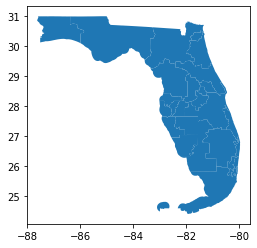

In [25]:
s = time.time()
print('getting from backup...')
tract_gdf = tract_gdf[tract_gdf['GEOCOMP'].apply(lambda x: False)]
tract_gdf = tract_gdf_bk

new_district_shapes_gdf.plot()


In [26]:
# new_district_shapes_gdf = geopandas.GeoDataFrame(data=None, columns=['new_district', 'geometry'], crs=tract_gdf.crs, geometry='geometry').set_index('new_district')
# for i in range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     print('merging tract shapes get district {0:,.0f} boundaries...'.format(i))
#     new_district_shapes_gdf.loc[i, 'geometry'] = unary_union(tract_gdf[tract_gdf['new_district'] == i].geometry.tolist())    
# #new_district_shapes_gdf = new_district_shapes_gdf.reset_index()
    
# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = cd_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]

# fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# ax.set_aspect('equal')
# #thedistricts = [x for x in cd_gdf['CD116'].drop_duplicates().tolist()]

# thedistricts = list(set([int(x) for x in cd_gdf['CD116'].drop_duplicates().tolist()]))

# legend_list = []

# print('ploting congressional districts...')
# for thiscd in thedistricts:
#     print('Plotting district {0:.0f}...'.format(thiscd))
#     new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].to_crs(epsg=theproj).plot(ax=ax, color=district_color_cycle[thiscd])
#     #cd_gdf[cd_gdf['CD116'] == thiscd].plot(ax=ax, color=district_color_cycle[thiscd])
#     legend_list.append(mpatches.Patch(color=district_color_cycle[thiscd], label='District {0:,.0f}'.format(thiscd)))
    
    
#     annotator = thiscd #parse_road_name(thisrow['FULLNAME'])
#     centerpoint = (unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.x, unary_union(new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd].geometry.tolist()).centroid.y)
#     #centerpoint = (new_district_shapes_gdf[new_district_shapes_gdf.index == thiscd]['INTPTLON'].values[0], cd_gdf[cd_gdf['CD116'] == thiscd]['INTPTLAT'].values[0])
#     ax.annotate(annotator, centerpoint, 
#                 color='black', backgroundcolor='white', ha='center', va='center', fontsize=2.25*scale)
    
# print('ploting census tracts...')
# tract_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.0625*scale)

# if (show_water):
#     print('ploting water areas...')
#     water_gdf.plot(ax=ax, color='blue')
    
# #state_gdf.to_crs(epsg=theproj).plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
# state_gdf.plot(ax=ax, color='none', edgecolor='black', lw=0.25*scale)
    
# ax.legend(handles=legend_list, fontsize=2.25*scale)

# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
#     ), fontsize=3*scale)
# else:
#     plt.title('Current Congressional Districts', fontsize=3*scale)

# plt.xticks(fontsize=2*scale)
# plt.yticks(fontsize=2*scale)

# plt.show()

# # #fig.get_size_inches()
# #cd_gdf[cd_gdf['CD116'] == 'ZZ']




In [27]:
################## MIAMI-DADE COUNTY #########################
# # # Populated Dade County
# xlimits = [-80.55, -80.15]
# ylimits = [25.4,25.95]

# SW of Miami City
# xlimits = [-80.45,-80.25]
# ylimits = [25.62,25.8]

# Tamiami / Kendall West
# xlimits = [-80.54,-80.425]
# ylimits = [25.68, 25.77]

# Miami / Miami Beach
# xlimits = [-80.35,-80.1]
# ylimits = [25.65,25.95]

# North of Miami
# xlimits = [-80.25,-80.1]
# ylimits = [25.85,25.95]

# NW of Miami
# xlimits = [-80.375,-80.175]
# ylimits = [25.75,25.95]

# NNW of Miami
# xlimits = [-80.395,-80.125]
# ylimits = [25.85,25.98]


# Remainder of Dade County (for District 24)
# xlimits = [-80.35,-80.165]
# ylimits = [25.85, 26]


################## BROWARD COUNTY #########################
# # # Populated Broward County
# xlimits = [-80.45,-80]
# ylimits = [25.9,26.35]

# South coast of Broward County / North coast of Dade County
# xlimits = [-80.215,-80.1]
# ylimits = [25.9,26.025]

# Fort Lauderdale
# xlimits = [-80.25,-80.05]
# ylimits = [25.95,26.25]

# Fort Lauderdale / Pompano Beach
# xlimits = [-80.3,-80]
# ylimits = [25.95,26.35]

# North of Pompano Beach
# xlimits = [-80.3,-80]
# ylimits = [26.25,26.34]

#  Washington Park / Franklin Park / Roosevelt Gardens / Boulevard Gardens
# xlimits = [-80.21,-80.17]
# ylimits = [26.12,26.15]


################## PALM BEACH COUNTY #########################
# # # South end of Palm Beach County
# xlimits = [-80.3,-80]
# ylimits = [26.3,26.4]


# # # North end of Palm Beach County
# xlimits = [-80.4,-80.1]
# ylimits = [26.4,26.74]

# # # West Palm Beach
# xlimits = [-80.3,-80]
# ylimits = [26.56,26.82]

#### Cities SW of WPB
# xlimits = [-80.17,-80.05]
# ylimits = [26.57,26.75]

#### All tracts SW of WPB
# xlimits = [-80.48,-80.08]
# ylimits = [26.4,26.8]

# # # West of Atlantis
# xlimits = [-80.2, -80.12]
# ylimits = [26.59, 26.63]

# # # West of Boca Raton
# xlimits = [-80.3,-80.1]
# ylimits = [26.3,26.42]

##### Central-west Palm Beach County
# xlimits = [-80.2,-80.08]
# ylimits = [26.36,26.74]


#### NNE Palm Beach County
# xlimits = [-80.4,-80]
# ylimits = [26.75,27]

#### North Palm Beach
# xlimits = [-80.15,-80]
# ylimits = [26.75,26.9]


#### Elbow of WPB City
# xlimits = [-80.17,-80.09]
# ylimits = [26.66,26.75]



############################ OTHER SOUTH FLORIDA ##########################
#### SOUTH FLORIDA
# xlimits = [-82.75,-80]
# ylimits = [25,27.5]

# Coast of Martin County
# xlimits = [-80.35,-80.03]
# ylimits = [26.95,27.2]

# Coast of St. Lucie County
# xlimits = [-80.47,-80.17]
# ylimits = [27.2,27.52]




################ HILLSBOROUGH COUNTY ##################
####### Tampa area
# xlimits = [-82.65,-82.15]
# ylimits = [27.65,28.2]

####### Clearwater to St. Pete
# xlimits = [-82.87,-82.57]
# ylimits = [27.68,27.95]

####### South of Clearwater ##########
# xlimits = [-82.86,-82.68]
# ylimits = [27.79,27.95]

####### NNE of Clearwater ############
# xlimits = [-82.81,-82.66]
# ylimits = [27.96,28.08]


######## Greenbrier / Safety Harbor ######
# xlimits = [-82.75,-82.7]
# ylimits = [27.93,28.03]



######## north part of Pinellas / west part of Hillsborough ########
# xlimits = [-82.81,-82.5]
# ylimits = [27.9,28.16]


####### Coast of Hernando County ############
# xlimits = [-82.7,-82.35]
# ylimits = [28.43,28.6]


####### South and East Hillsborough County ############
# xlimits = [-82.5,-82.15]
# ylimits = [27.65,28]


####### Coast of Pasco County ############
# xlimits = [-82.8,-82.55]
# ylimits = [28.16,28.44]


####### South-central Pasco County ############
# xlimits = [-82.3,-82.1]
# ylimits = [28.16,28.34]



####################### POLK COUNTY ############################
# ###### Western Polk County #######
# xlimits = [-82.07,-81.7]
# ylimits = [27.77,28]

# ###### NW Polk County #######
# xlimits = [-82.07,-81.7]
# ylimits = [28,28.3]




################## PANHANDLE #########################

# WESTERN PANHANDLE
# xlimits = [-88,-83]
# ylimits = [29,31]

# EASTERN PANHANDLE TO JACKSONVILLE
# xlimits = [-84,-81]
# ylimits = [29,30.7]

# Pensacola area / District 1
# xlimits = [-87.75,-85.5]
# ylimits = [30,31.25]


################## JACKSONVILLE #########################

## WESTERN EDGE OF JACKSONVILLE
# xlimits = [-82.1,-81.7]
# ylimits = [29.4,30.8]
        
# ## DOWNTOWN JACKSONVILLE 
# xlimits = [-81.9,-81.45]
# ylimits = [30.25,30.45]
    
# ## Port Jax
# xlimits = [-81.6,-81.35]
# ylimits = [30.2,30.4]

## SE Jax
# xlimits = [-81.7,-81.4]
# ylimits = [30.1,30.35]

# ## SE Downtown Jax
# xlimits = [-81.56,-81.35]
# ylimits = [30.2,30.325]




################ CENTRAL FLORIDA #########################
# DELAND AREA AND NE SEMINOLE
# xlimits = [-81.6,-81.1]
# ylimits = [28.8,29.2]

# # DELAND
# # xlimits = [-81.4,-81.2]
# # ylimits = [28.93,29.08]

# # LAKE / SEMINOLE
# xlimits = [-81.95,-81.65]
# ylimits = [28.75,28.95]


############ Orlando city ##################
# xlimits = [-81.7,-81.1]
# ylimits = [28.36,28.64]


############ East Orange County ##################
# xlimits = [-81.35,-81.05]
# ylimits = [28.35,28.62]

############ NW Orange County ##################
# xlimits = [-81.7,-81.4]
# ylimits = [28.6,28.8]

############ East of Disney World ##################
# xlimits = [-81.55,-81.38]
# ylimits = [28.35,28.48]

############ Rio Pinar ##################
# xlimits = [-81.34,-81.23]
# ylimits = [28.47,28.56]


############ Orlando area / District 7 ##################
# xlimits = [-81.65,-81.2]
# ylimits = [28.36,28.63]

############ Union Park ##################
# xlimits = [-81.26,-81.2]
# ylimits = [28.54,28.59]







############ Kissimmee Area ##################
# xlimits = [-81.66,-81.16]
# ylimits = [28.1,28.36]


############ POLK COUNTY ##################

############ N Polk County ##################
# xlimits = [-82.05,-81.45]
# ylimits = [28,28.35]


############ NE Polk / NW Osceola County ##################
# xlimits = [-81.85, -81.25]
# ylimits = [27.8, 28.35]


############ Center-South Eastern Polk County ##################
# xlimits = [-82,-81.2]
# ylimits = [27.71,28.3]


# ############ Center-East Polk County ##################
# xlimits = [-82,-81.75]
# ylimits = [28,28.08]


### Southern Polk County
# xlimits = [-81.95,-81.59]
# ylimits = [27.64,28.06]


### Wahneta / Eagle Lake
# xlimits = [-81.81,-81.65]
# ylimits = [27.93,28.08]



############ SE Marion County ############
# xlimits = [-82.05,-81.65]
# ylimits = [28.7,29.16]



############ GULF COAST SOUTH OF TAMPA ############
#### Coast of Manatee County
# xlimits = [-82.8,-82.37]
# ylimits = [27.4,27.65]


#### Coast of Sarasota County - North
# xlimits = [-82.65,-82.44]
# ylimits = [27.18,27.38]


#### Coast of Sarasota County - South
# xlimits = [-82.52,-82.18]
# ylimits = [26.96,27.16]


#### North Port / Port Charlotte area
# xlimits = [-82.4,-81.9]
# ylimits = [26.76,27.11]


#### Across the river from Cape Coral
# xlimits = [-82.1,-81.78]
# ylimits = [26.4,26.6]


# #### Across the river from Cape Coral but east
# xlimits = [-81.95,-81.63]
# ylimits = [26.35,26.6]


# #### Eastern Charlotte and Lee Counties
# xlimits = [-82.05,-81.55]
# ylimits = [26.35,26.75]


### North of Highlands County (N of Sebring)
# xlimits = [-81.6,-81.4]
# ylimits = [27.45,27.62]



############ BREVARD COUNTY ###############

### Central Brevard County
# xlimits = [-80.875,-80.45]
# ylimits = [28.16,28.66]




######## VOLUSIA COUNTY ##########
# Daytona Beach area
# xlimits = [-81.5,-80.95]
# ylimits = [29.1,29.35]

# Port Orange/Ponce Inlet/Edgewater area
# xlimits = [-81.2, -80.85]
# ylimits = [28.85,29.15]

# SE Volusia
# xlimits = [-81.35,-81]
# ylimits = [28.8,29.05]



#### SOUTH FLORIDA
# xlimits = [-82.75,-80]
# ylimits = [25,28]


# Coast of Hernando County
# xlimits = [-82.7,-82.35]
# ylimits = [28.43,28.6]




# Daytona Beach area
# xlimits = [-81.35,-81.05]
# ylimits = [29.1,29.4]


# W Volusia County
# xlimits = [-81.45,-81]
# ylimits = [28.8,29.1]

# Orlando  /  D7
# xlimits = [-81.65,-81.2]
# ylimits = [28.36,28.63]

## NE Orange County (Goldenrod area)
# xlimits = [-81.35,-81.22]
# ylimits = [28.56,28.61]

##  W of Orlando
# xlimits = [-81.6,-81.45]
# ylimits = [28.48,28.67]


# NW Orange County (Apopka area)
# xlimits = [-81.66,-81.42]
# ylimits = [28.48,28.8]


#### Seminole and East Orange County
# xlimits = [-81.48,-80.94]
# ylimits = [28.43,28.86]

#### Azalea Park / University
# xlimits = [-81.34,-81.11]
# ylimits = [28.48,28.64]

##  E Volusia
# xlimits = [-81.44,-81.16]
# ylimits = [28.81,29.14]


# ### Central Brevard County
# xlimits = [-80.85,-80.58]
# ylimits = [28.28,28.58]


#### E Pasco County
# xlimits = [-82.62,-82.08]
# ylimits = [28.16,28.48]


# ######## Central Marion County
# xlimits = [-82.25,-81.8]
# ylimits = [29.05,29.4]

